In [ ]:
import os
import json
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from keras.optimizers import Adam
from google.colab.patches import cv2_imshow
from google.colab import files
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.layers import BatchNormalization

import matplotlib.pyplot as plt


In [ ]:
uploaded = files.upload() 

Saving 00100.PNG to 00100.PNG
Saving 00101.PNG to 00101.PNG
Saving 00102.PNG to 00102.PNG
Saving 00103.PNG to 00103.PNG
Saving 00104.PNG to 00104.PNG
Saving 00105.PNG to 00105.PNG
Saving 00106.PNG to 00106.PNG
Saving 00107.PNG to 00107.PNG
Saving 00108.PNG to 00108.PNG
Saving 00109.PNG to 00109.PNG
Saving 00110.PNG to 00110.PNG
Saving 00111.PNG to 00111.PNG
Saving 00112.PNG to 00112.PNG
Saving 00113.PNG to 00113.PNG
Saving 00114.PNG to 00114.PNG
Saving 00115.PNG to 00115.PNG
Saving 00116.PNG to 00116.PNG
Saving 00117.PNG to 00117.PNG
Saving 00118.PNG to 00118.PNG
Saving 00119.PNG to 00119.PNG
Saving 00120.PNG to 00120.PNG
Saving 00121.PNG to 00121.PNG
Saving 00122.PNG to 00122.PNG
Saving 00123.PNG to 00123.PNG
Saving 00124.PNG to 00124.PNG
Saving 00125.PNG to 00125.PNG
Saving 00126.PNG to 00126.PNG
Saving 00127.PNG to 00127.PNG
Saving 00128.PNG to 00128.PNG
Saving 00129.PNG to 00129.PNG
Saving 00130.PNG to 00130.PNG


In [ ]:
PATH_ANNOTATION_JSON = '100-130.json'
annotations = json.load(open(PATH_ANNOTATION_JSON, 'r'))
imgs = json.load(open(PATH_ANNOTATION_JSON, 'r'))

In [ ]:
print(imgs)

{'00000.PNG147925': {'filename': '00000.PNG', 'size': 147925, 'regions': [], 'file_attributes': {}}, '00001.PNG148428': {'filename': '00001.PNG', 'size': 148428, 'regions': [], 'file_attributes': {}}, '00002.PNG131405': {'filename': '00002.PNG', 'size': 131405, 'regions': [], 'file_attributes': {}}, '00003.PNG132034': {'filename': '00003.PNG', 'size': 132034, 'regions': [], 'file_attributes': {}}, '00004.PNG158176': {'filename': '00004.PNG', 'size': 158176, 'regions': [], 'file_attributes': {}}, '00005.PNG154968': {'filename': '00005.PNG', 'size': 154968, 'regions': [], 'file_attributes': {}}, '00006.PNG139473': {'filename': '00006.PNG', 'size': 139473, 'regions': [], 'file_attributes': {}}, '00007.PNG138427': {'filename': '00007.PNG', 'size': 138427, 'regions': [], 'file_attributes': {}}, '00008.PNG130430': {'filename': '00008.PNG', 'size': 130430, 'regions': [], 'file_attributes': {}}, '00009.PNG132022': {'filename': '00009.PNG', 'size': 132022, 'regions': [], 'file_attributes': {}},

<ipython-input-59-3b8326a3cef9>:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, arr = plt.subplots(1, 1, figsize=(15, 15))


Images shape: (31, 128, 128, 3)
Masks shape: (31, 128, 128, 1)


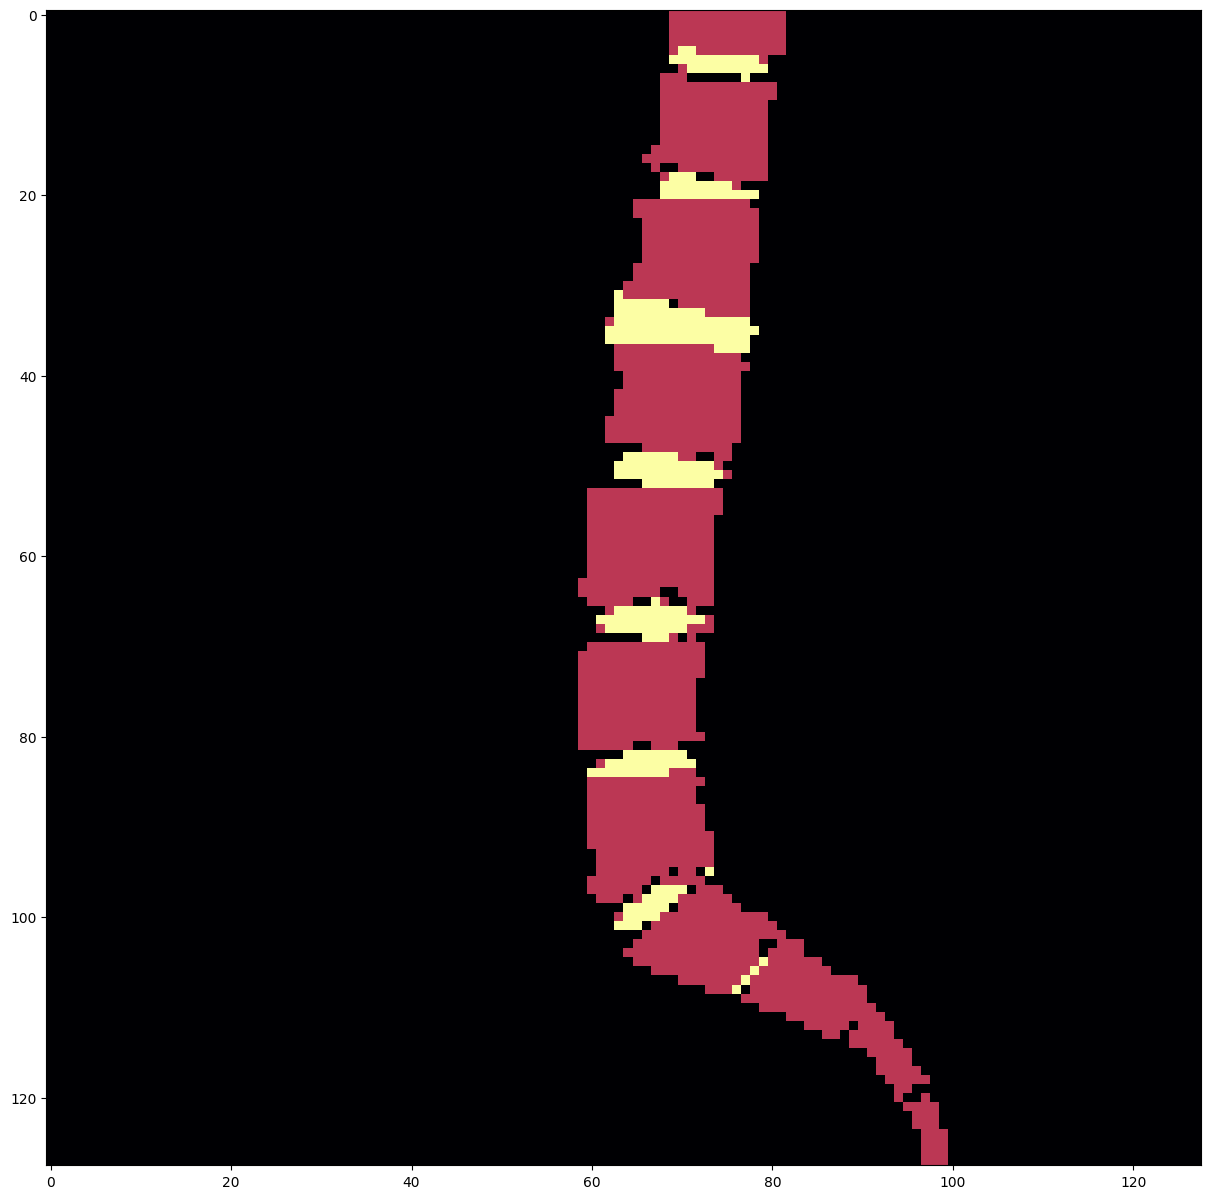

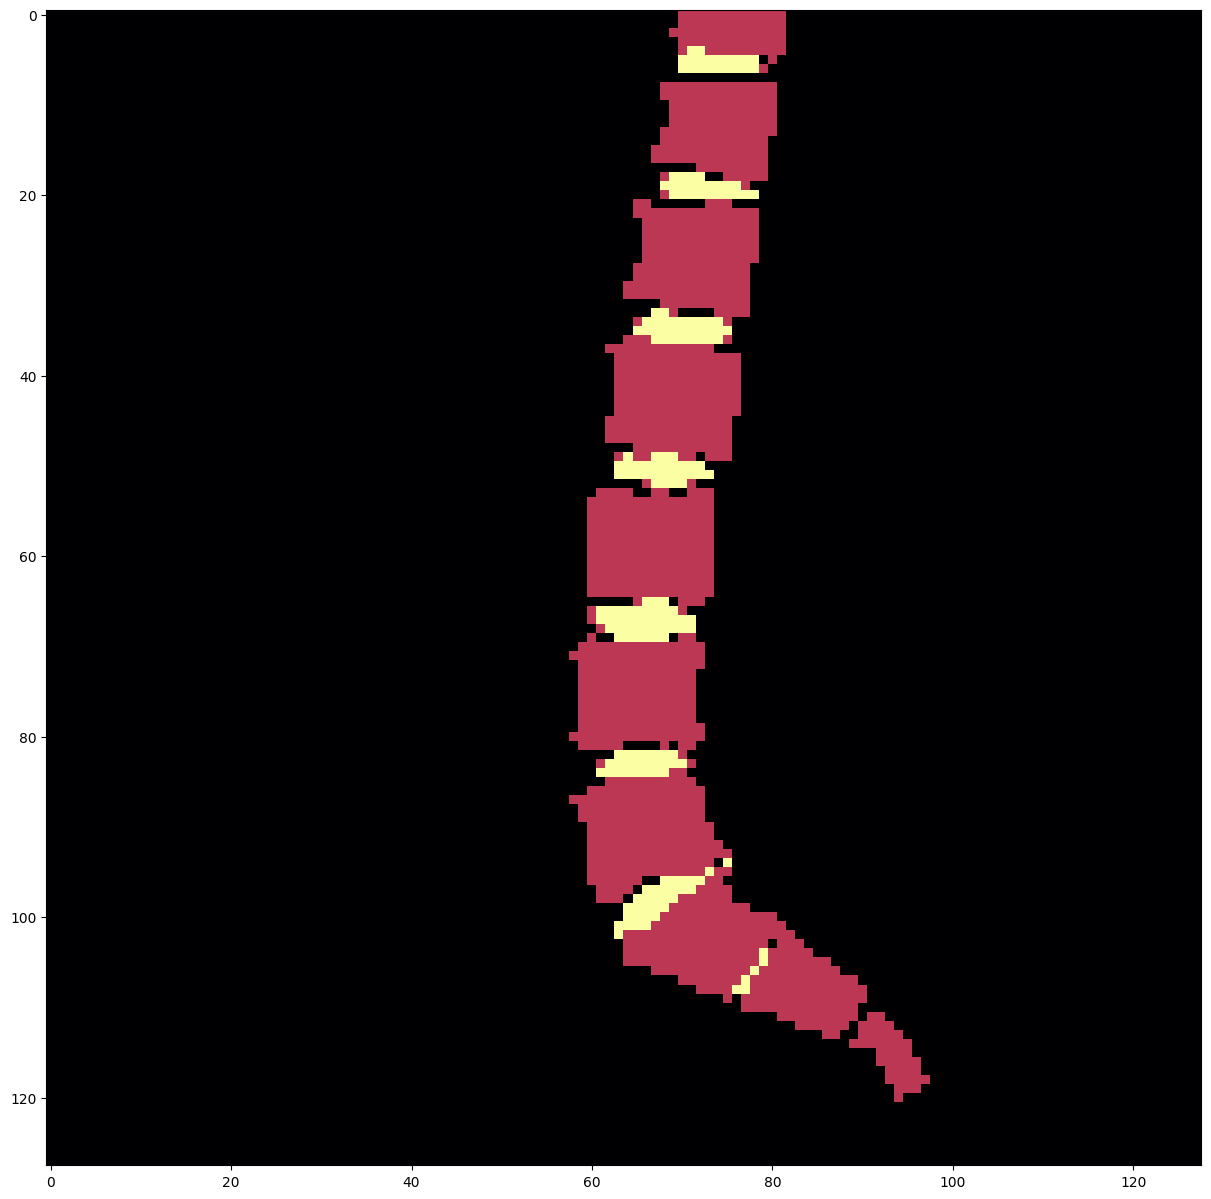

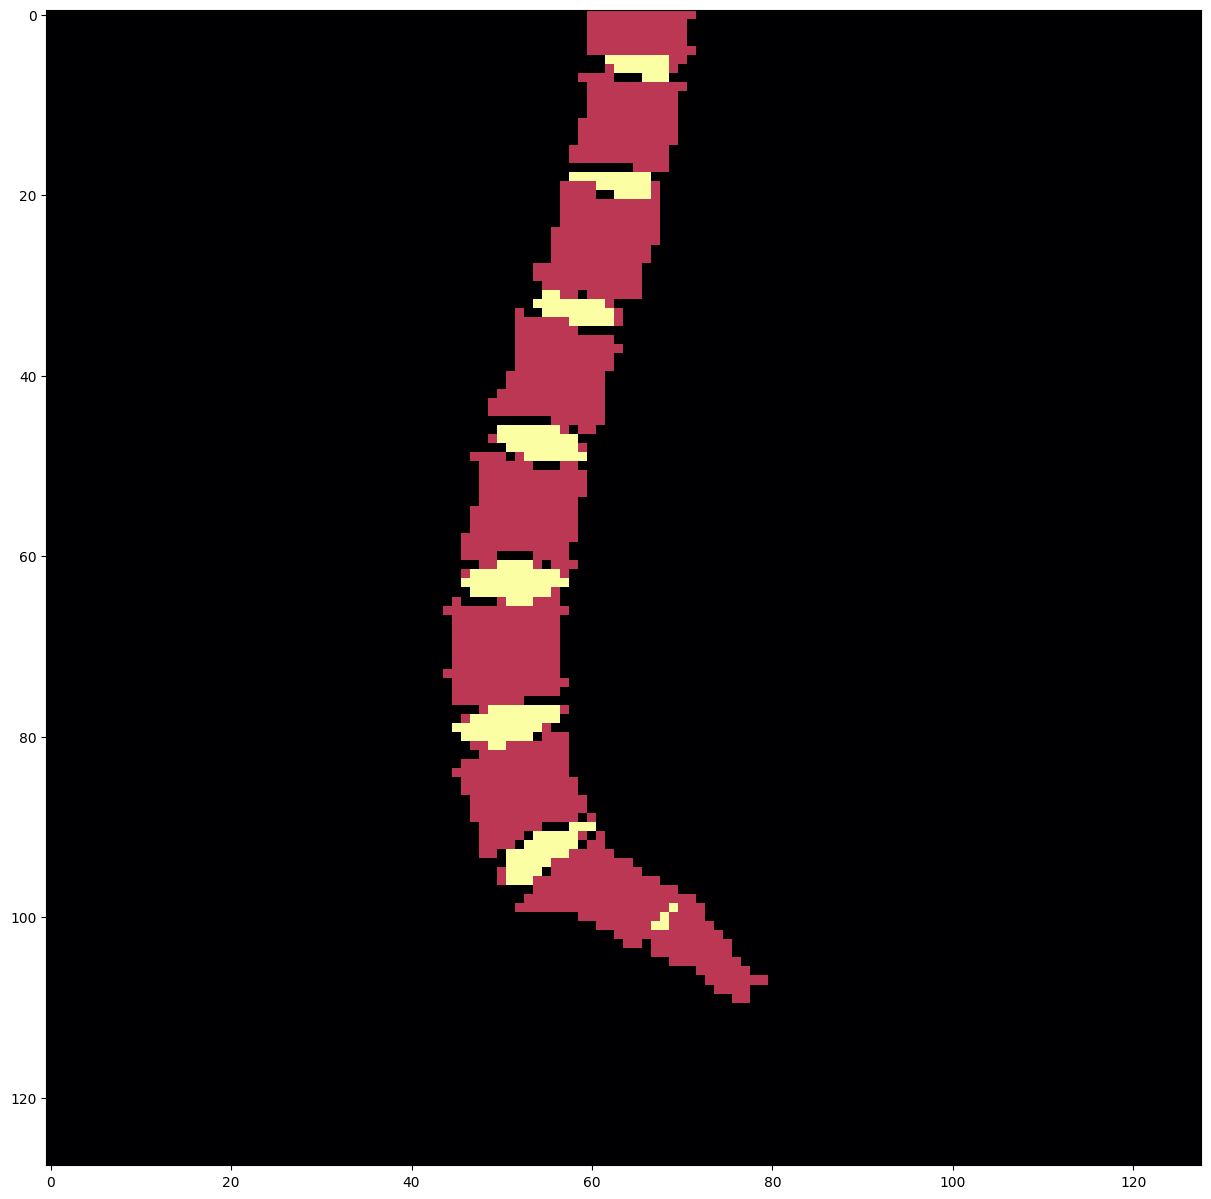

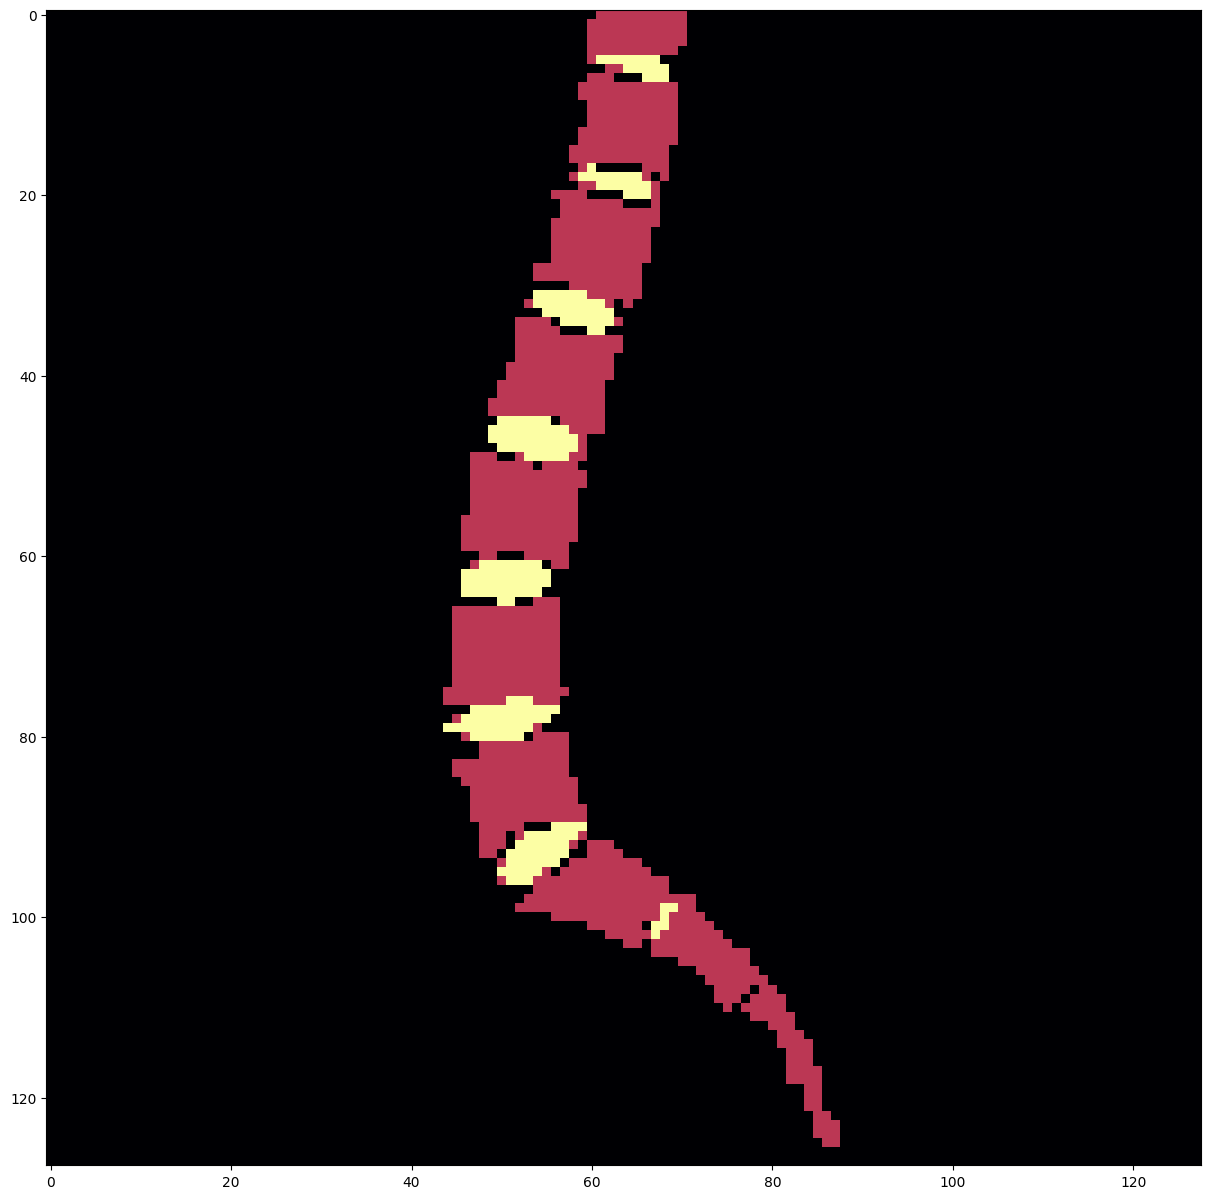

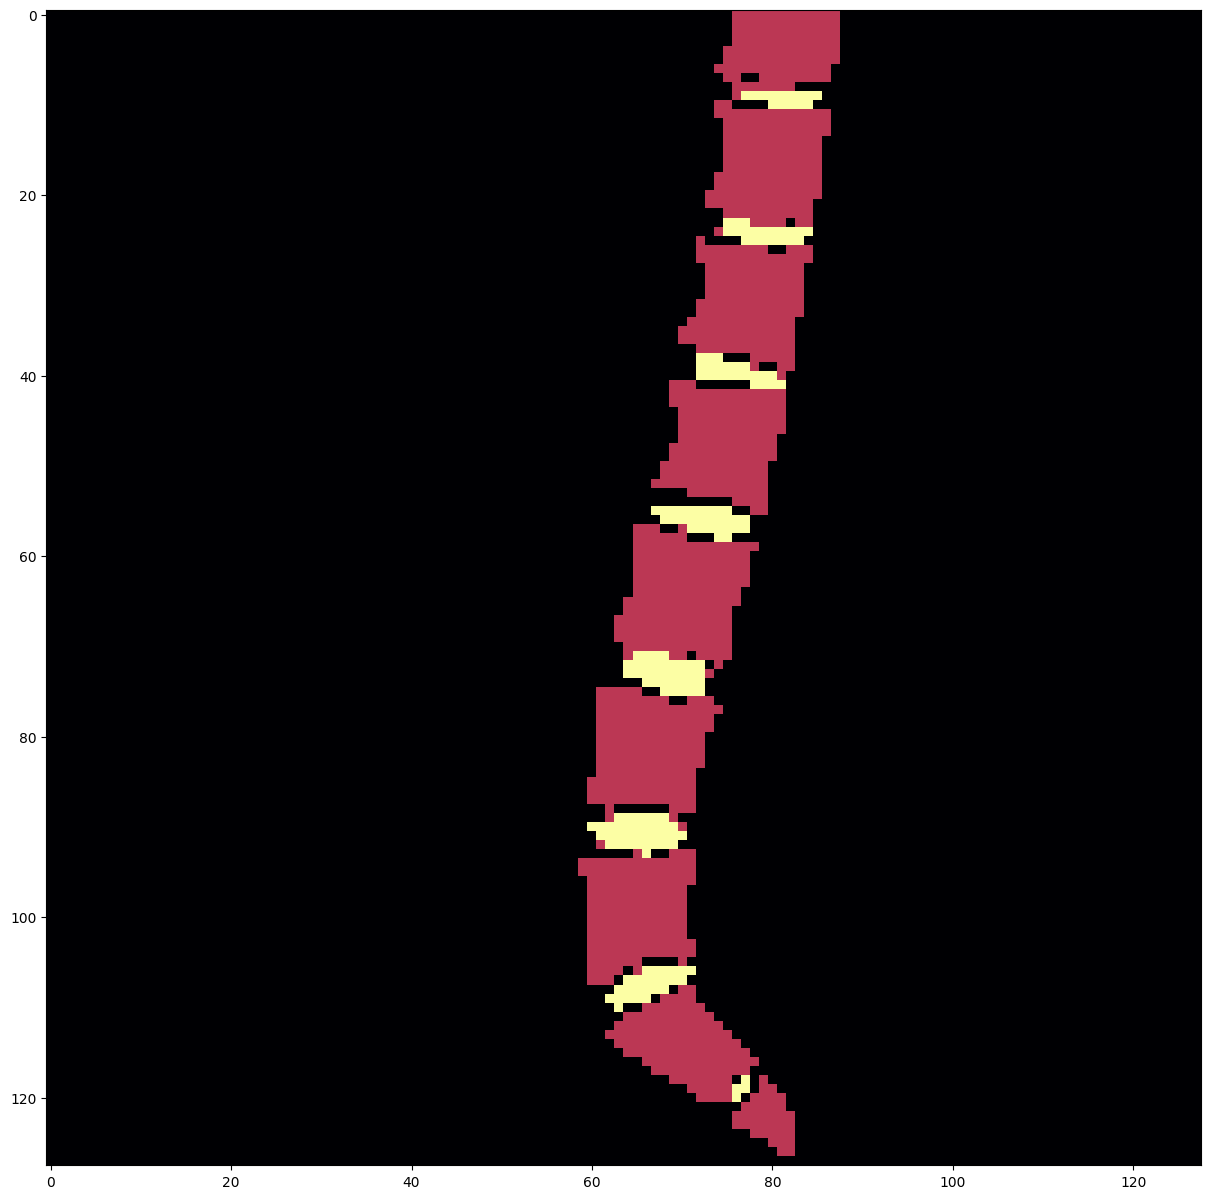

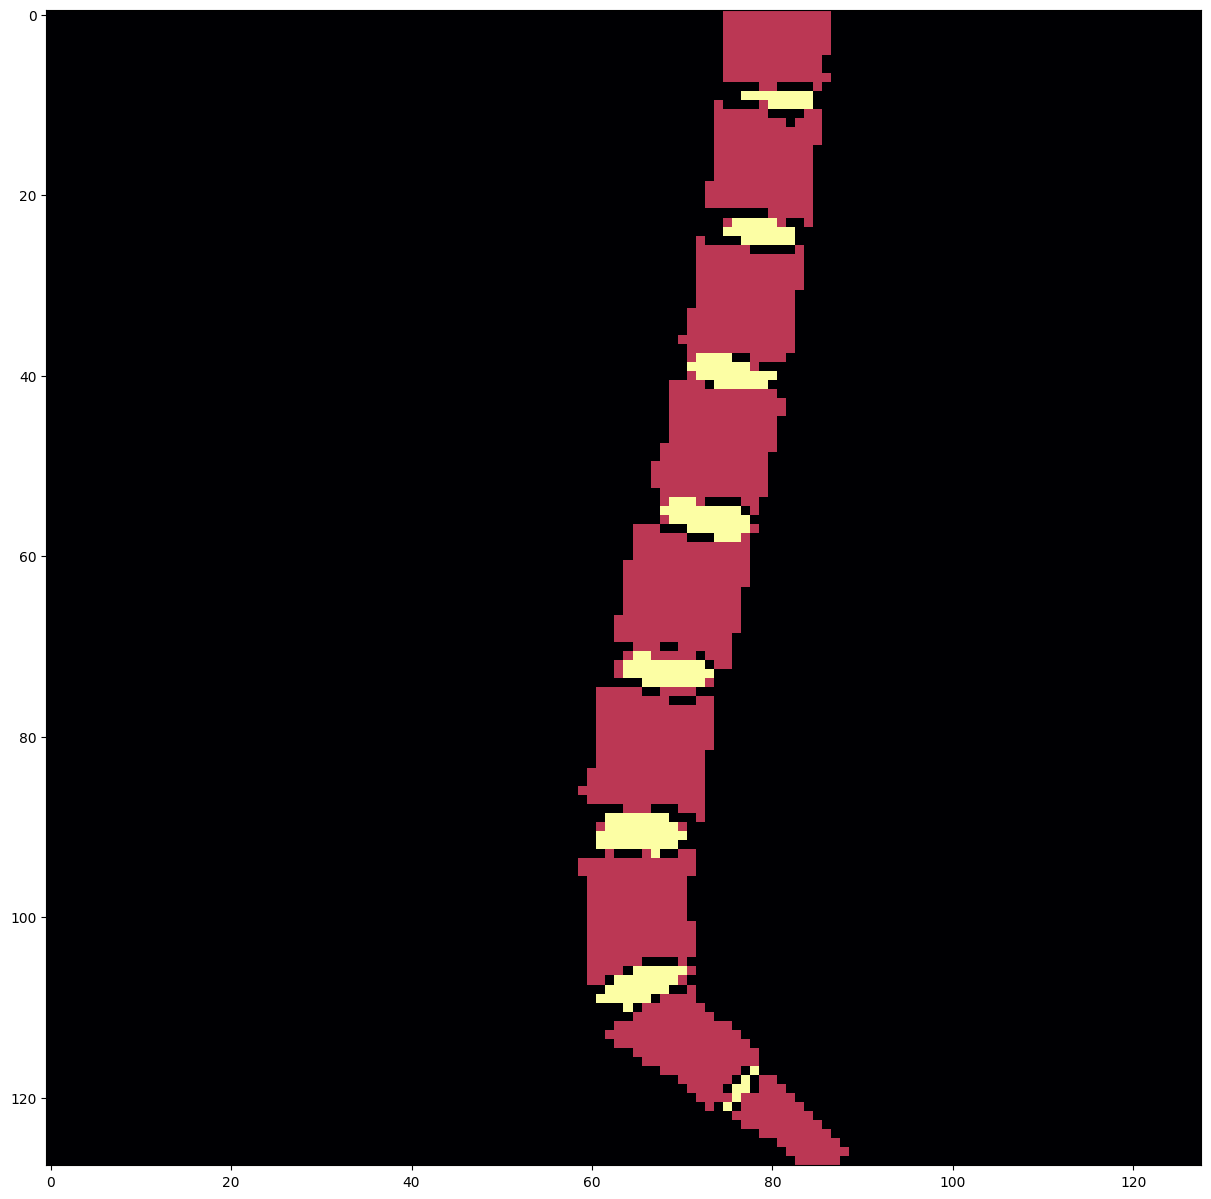

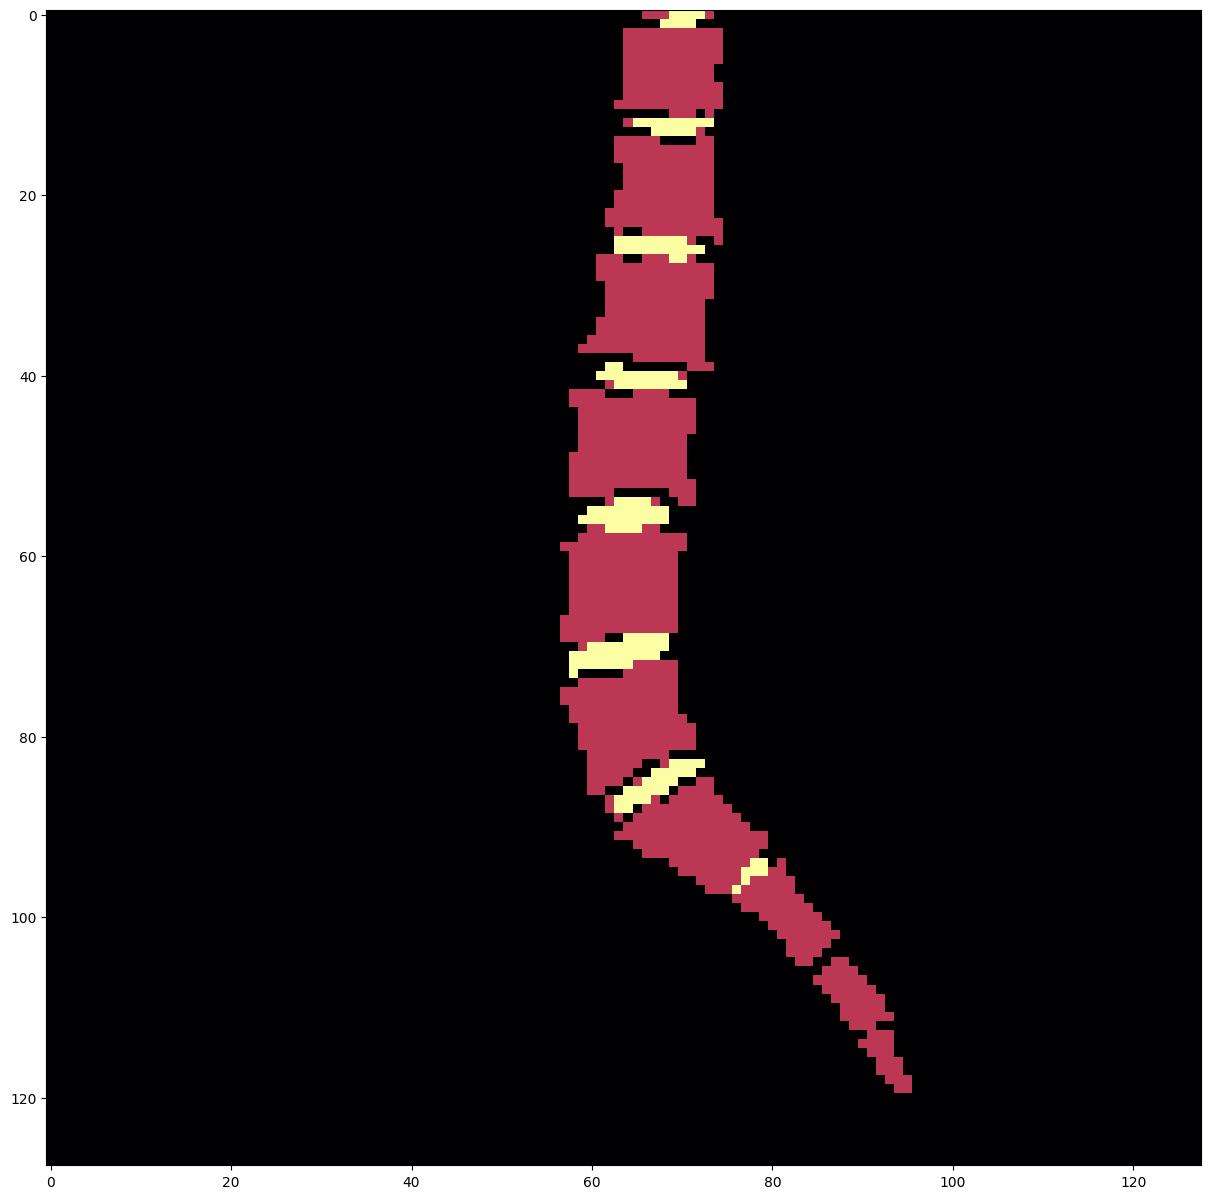

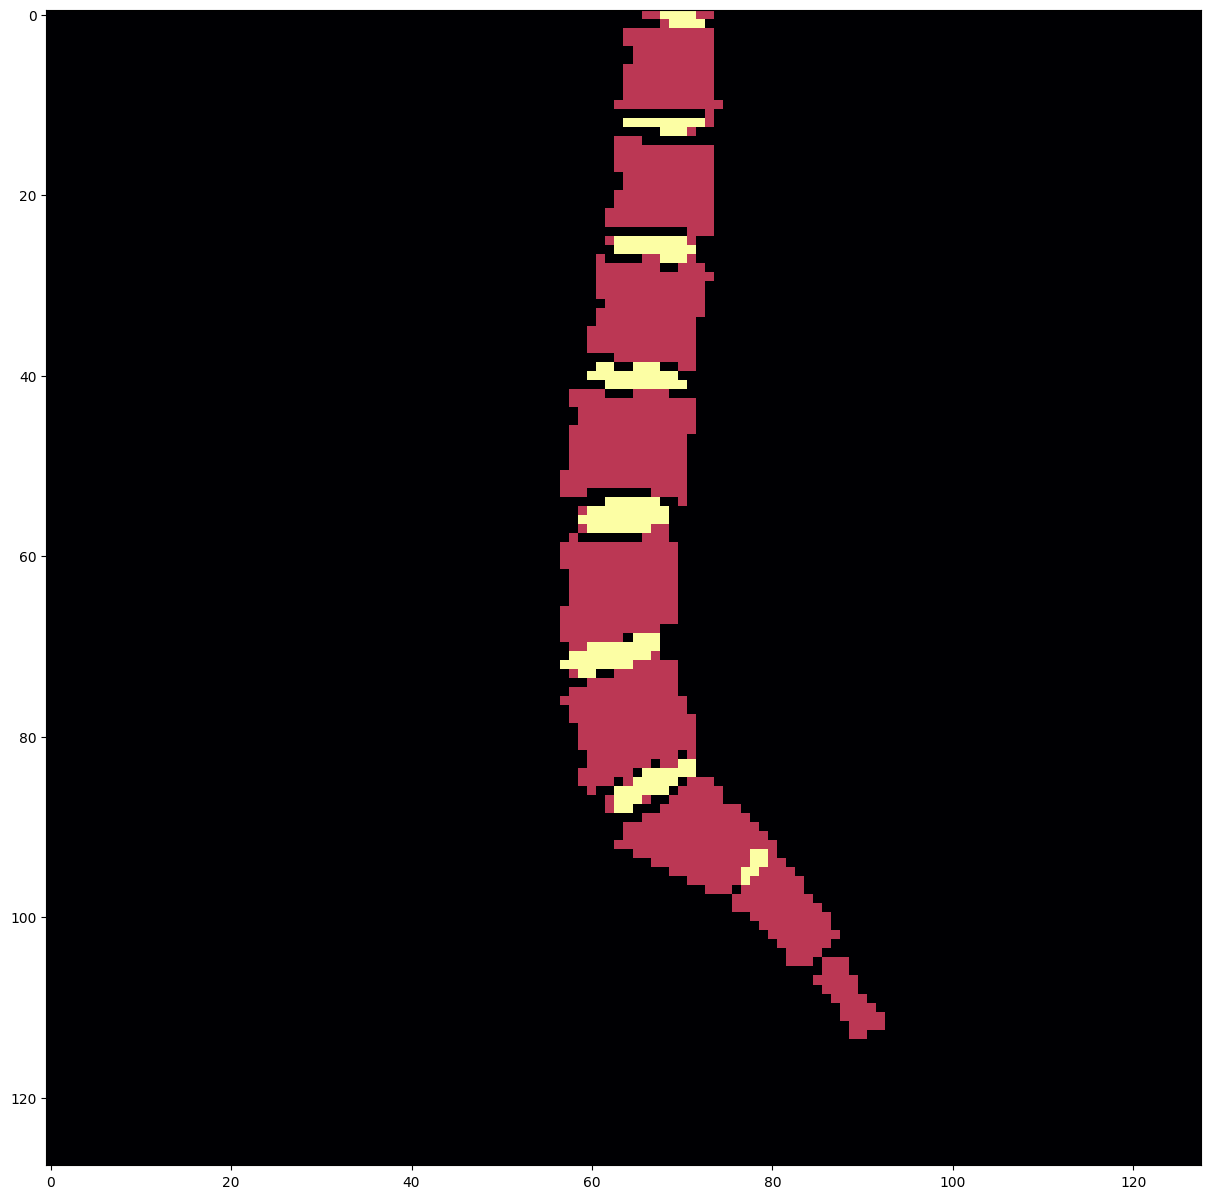

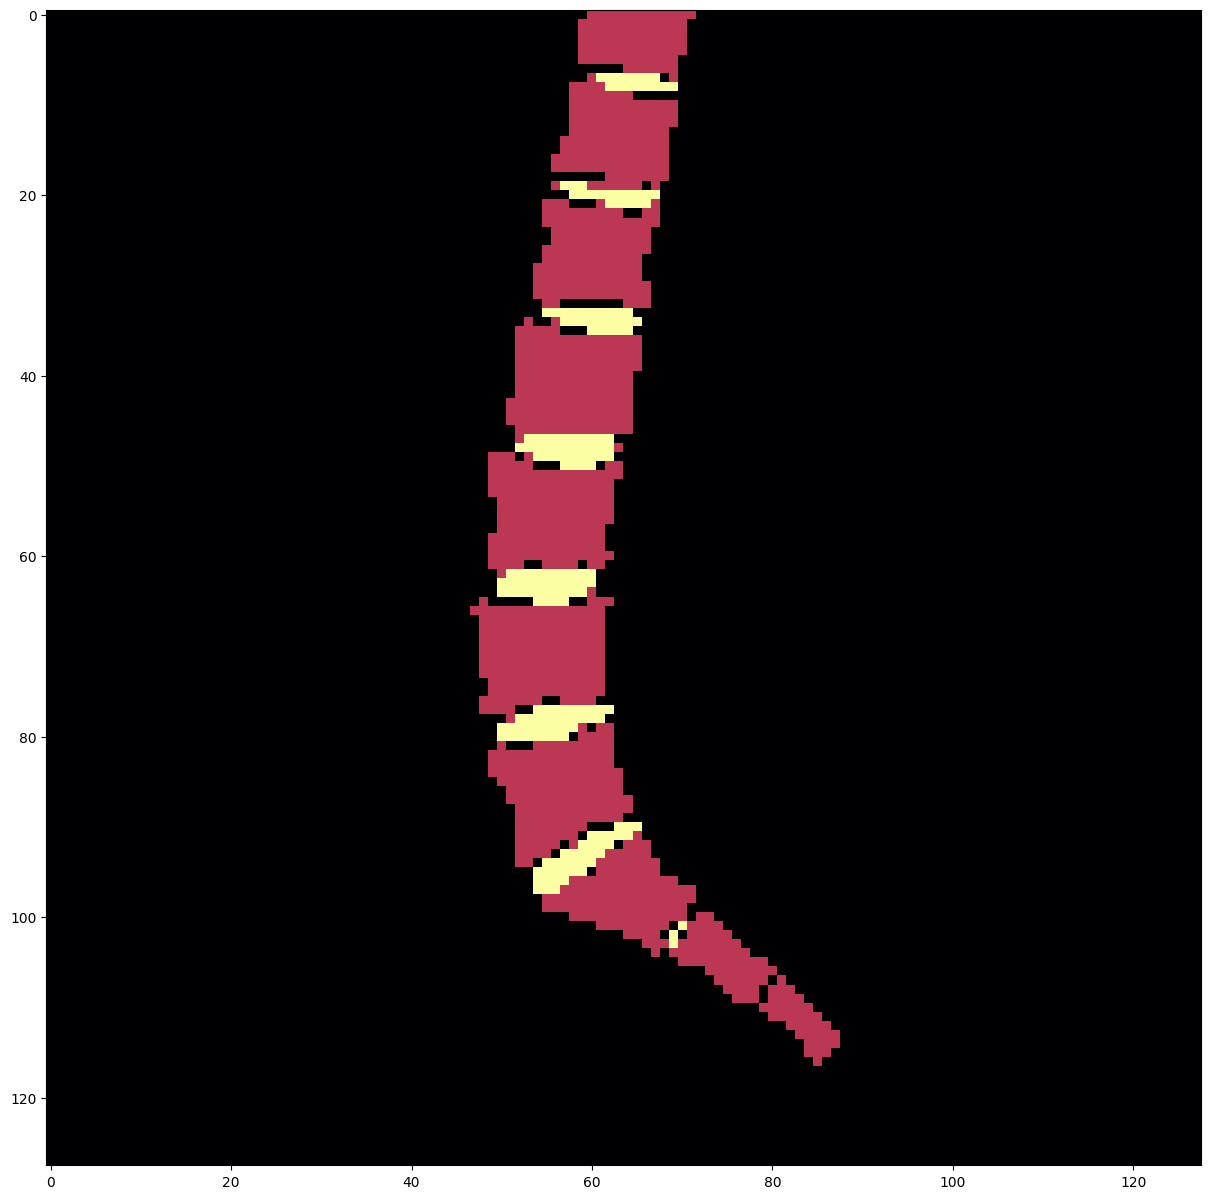

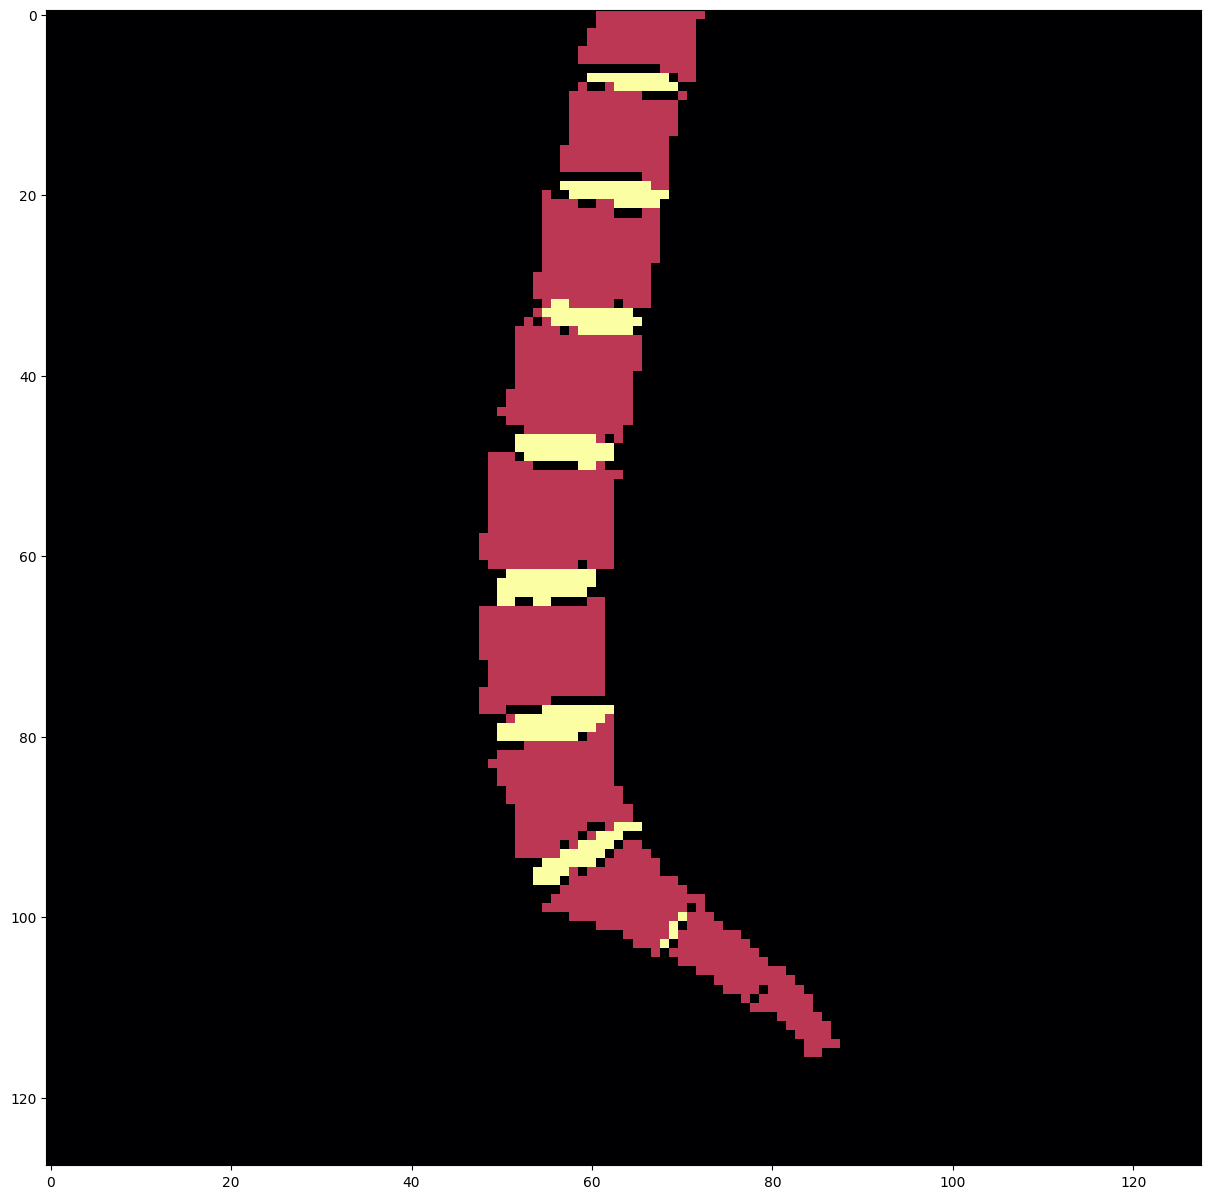

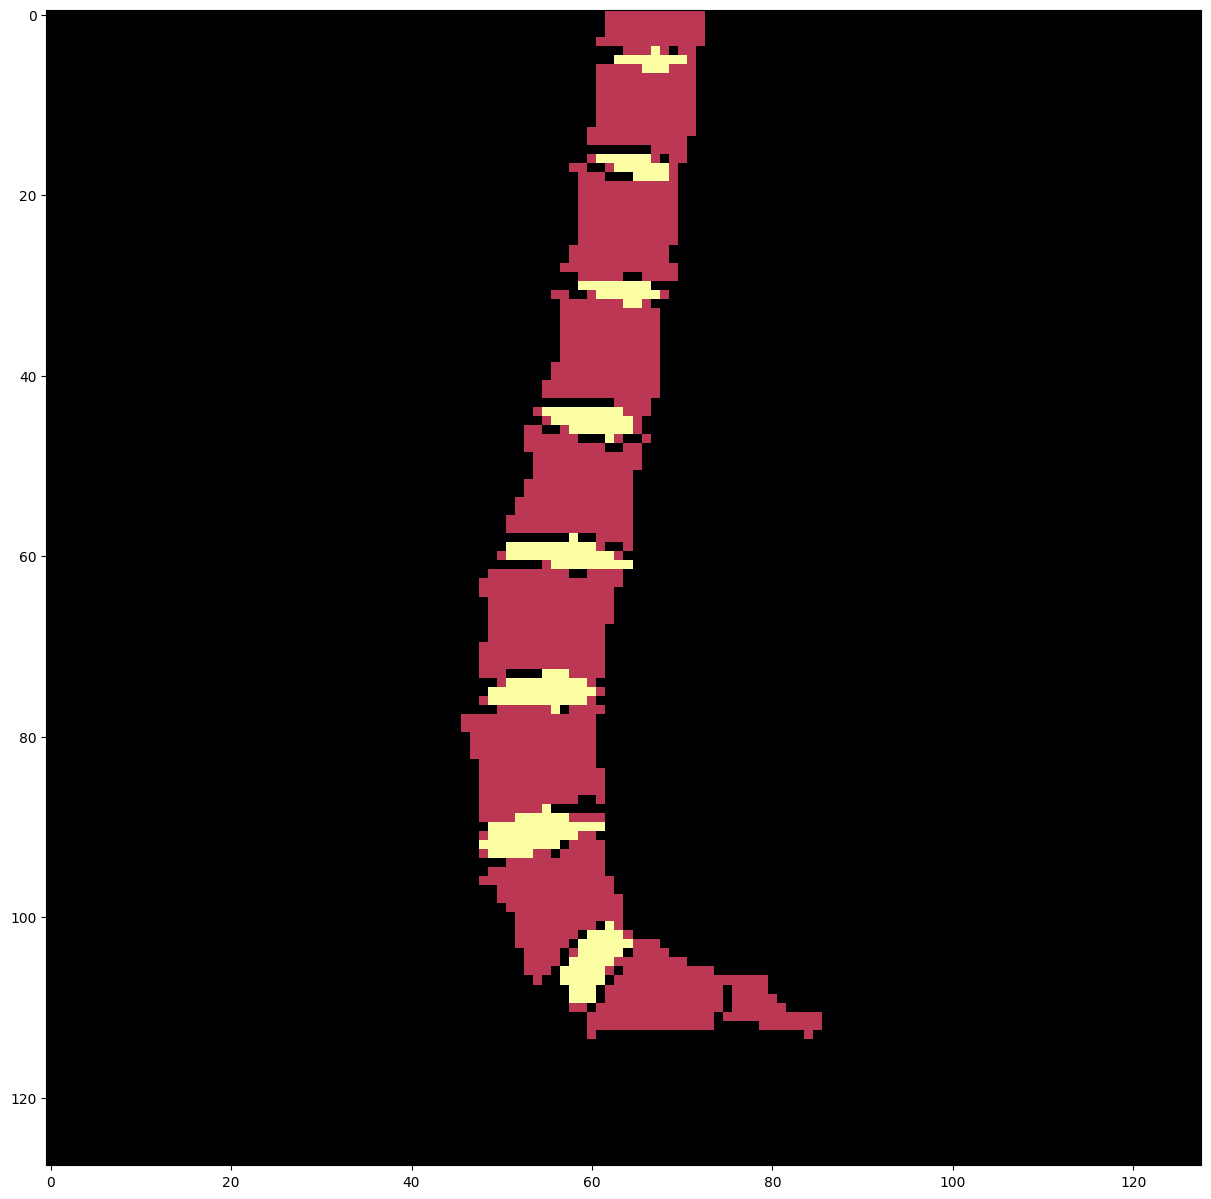

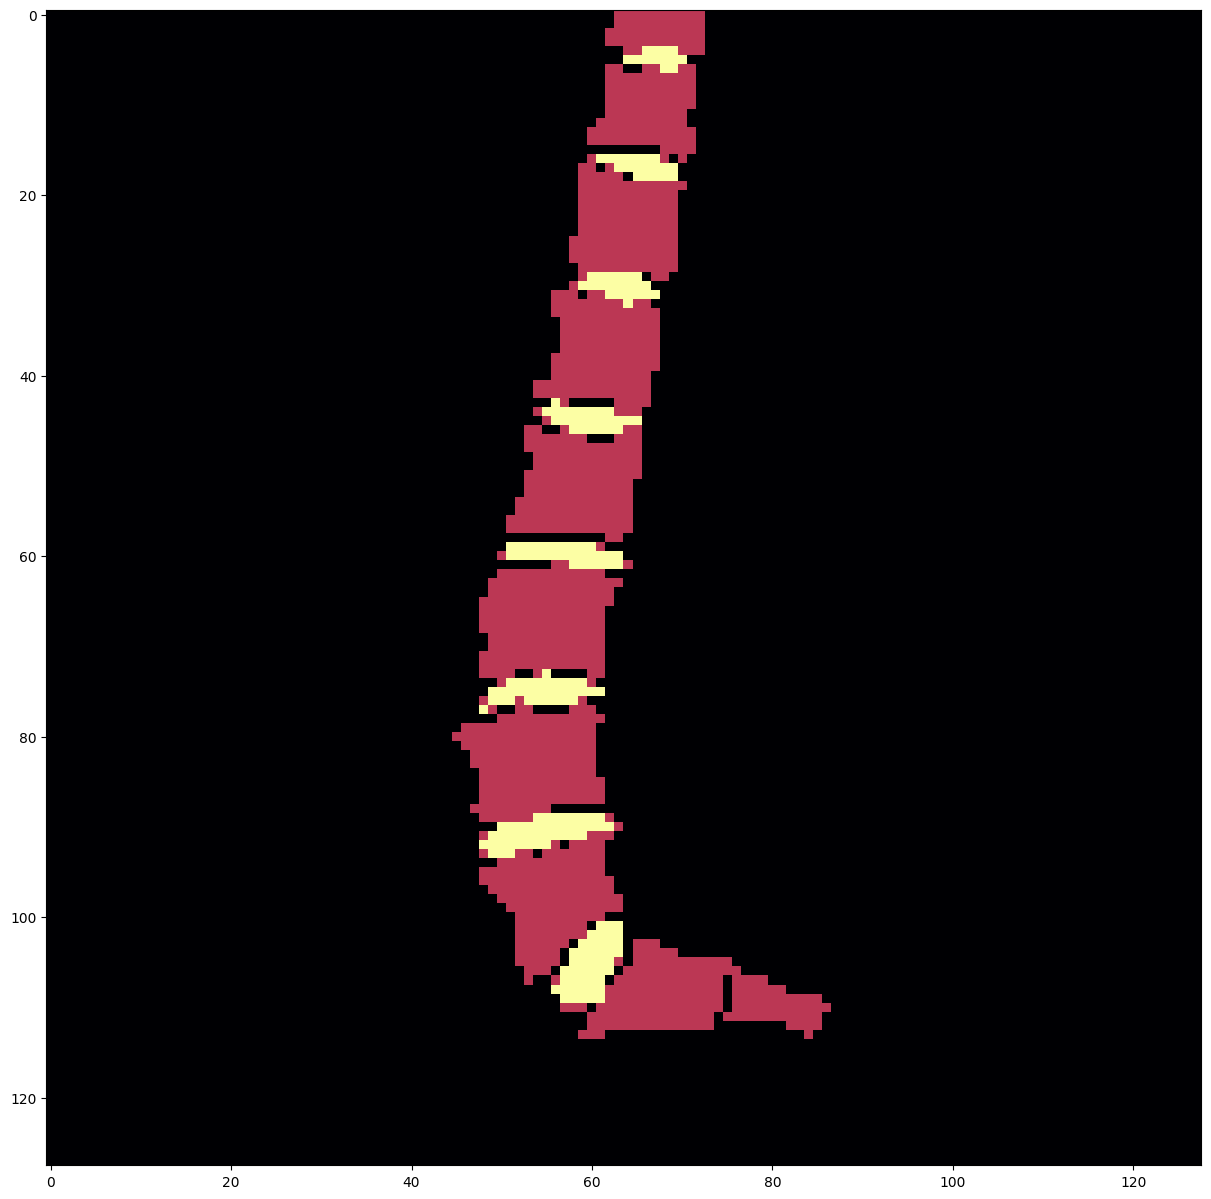

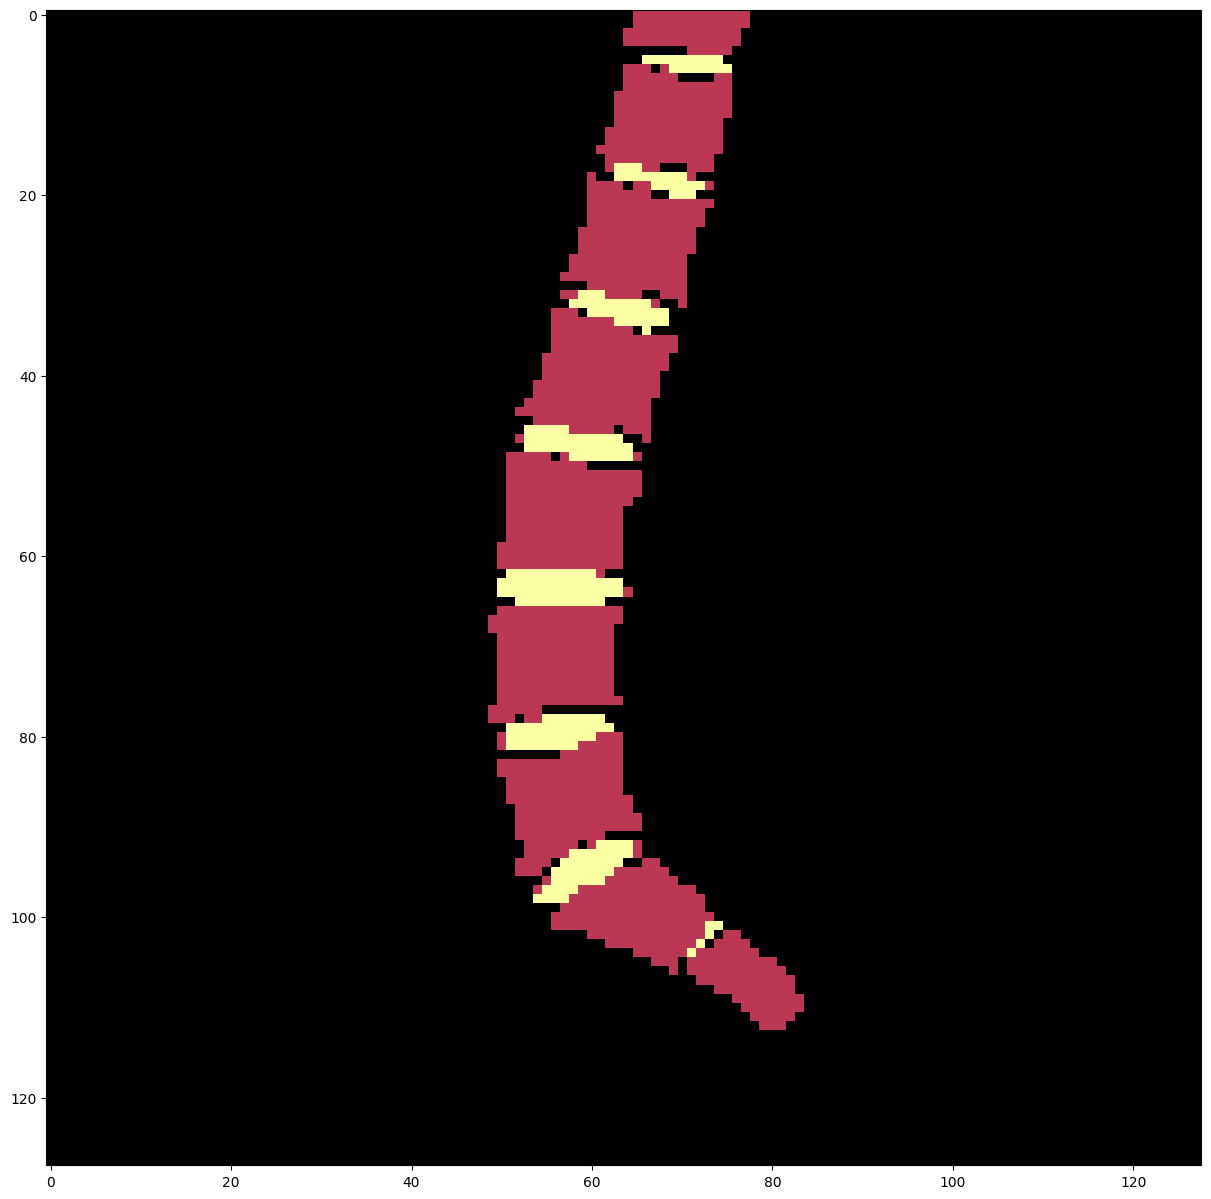

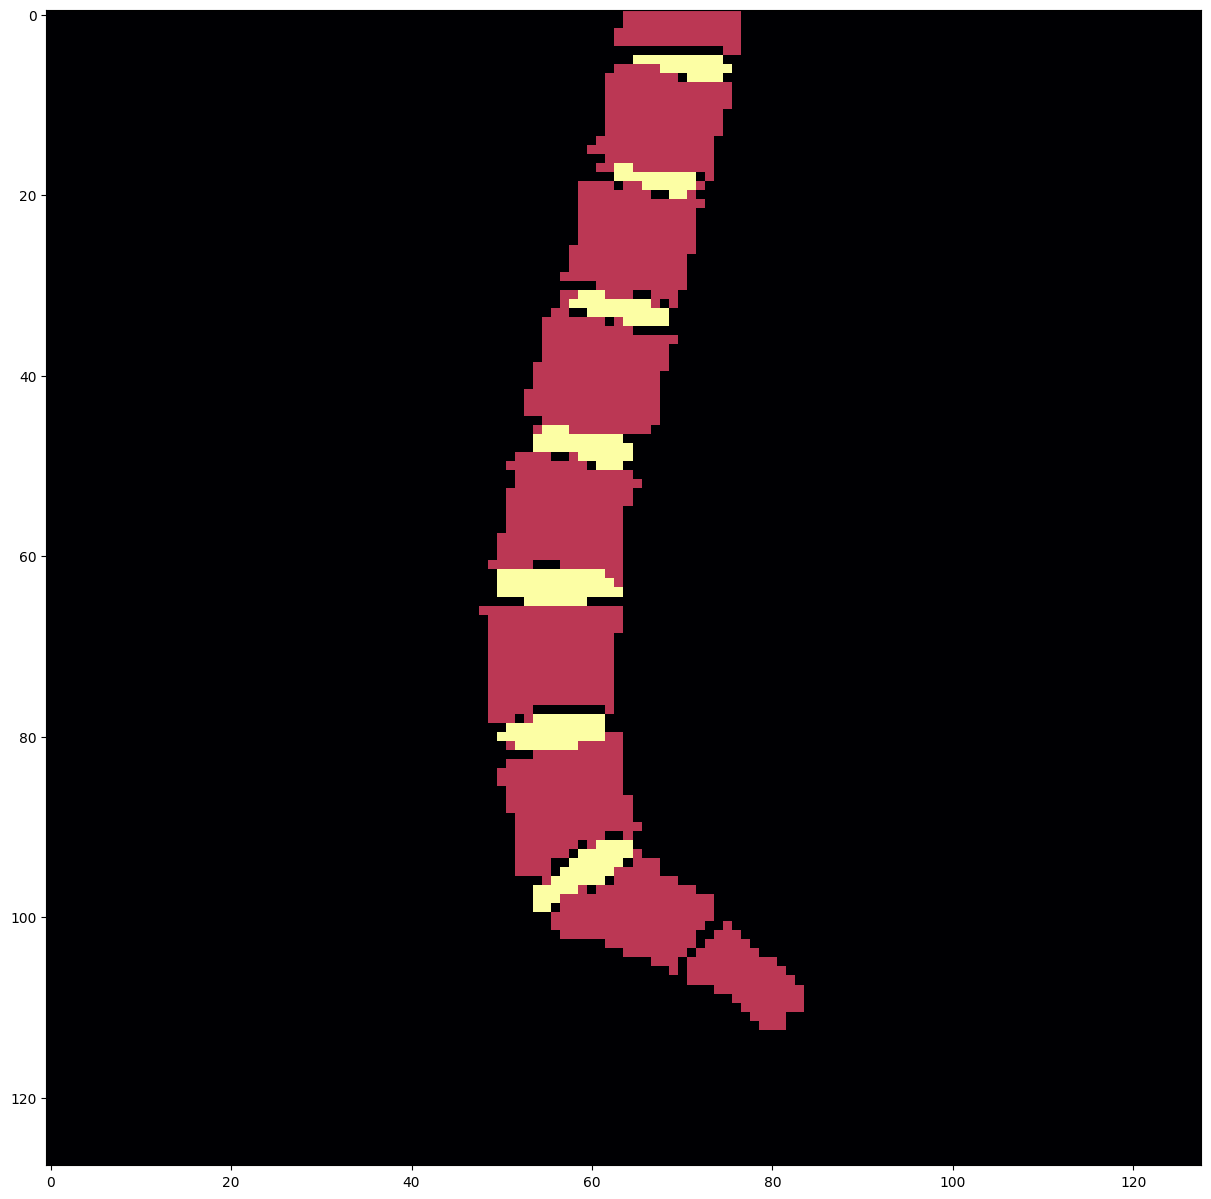

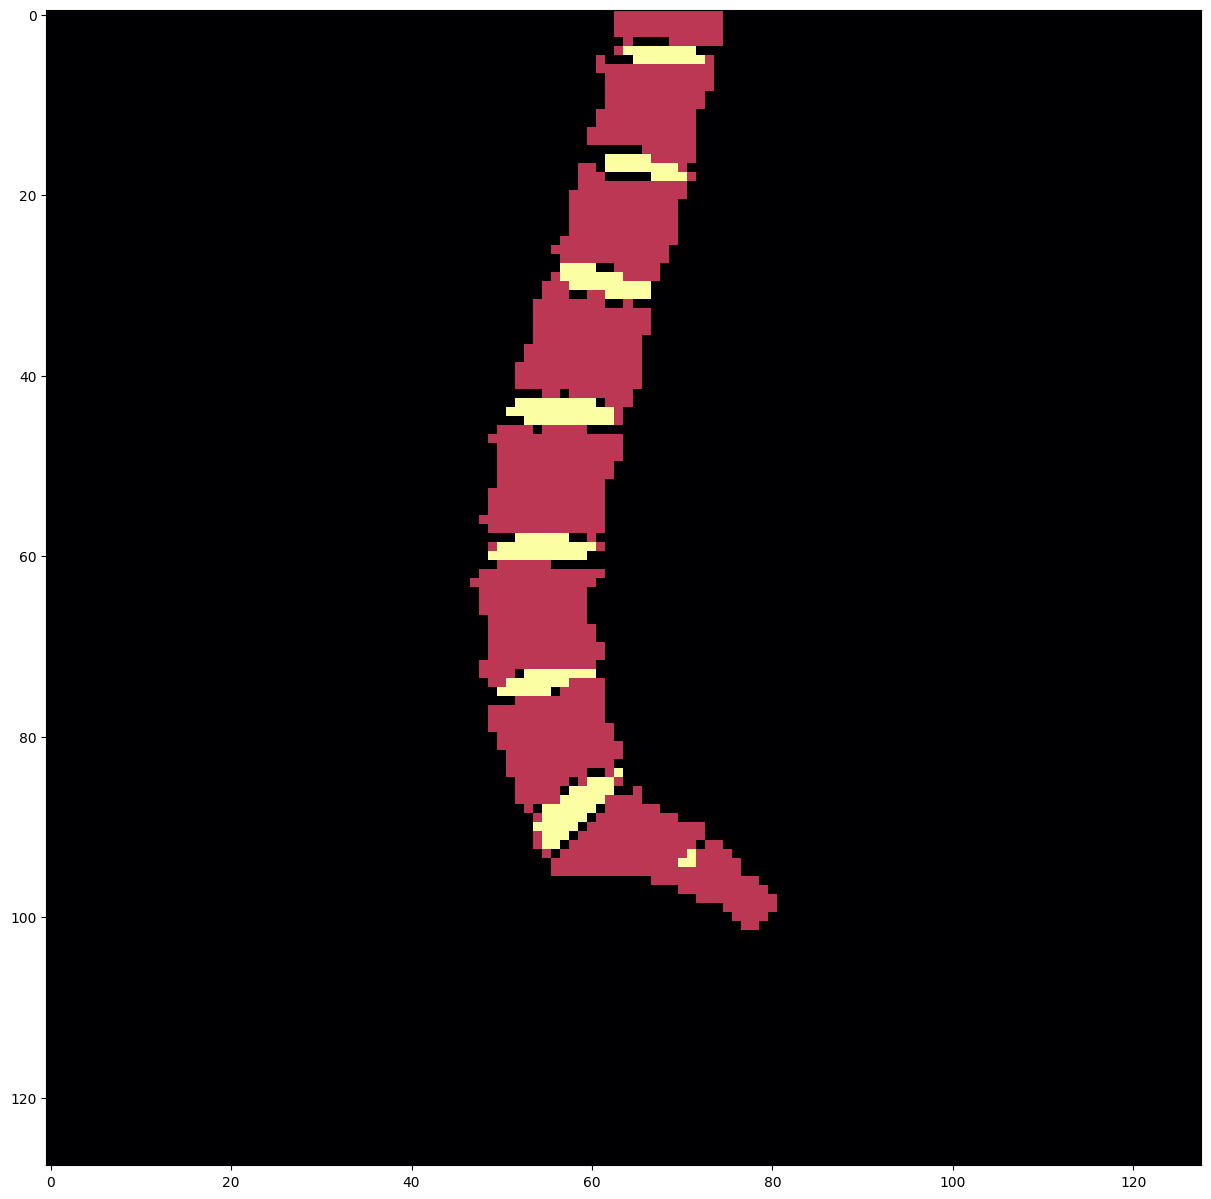

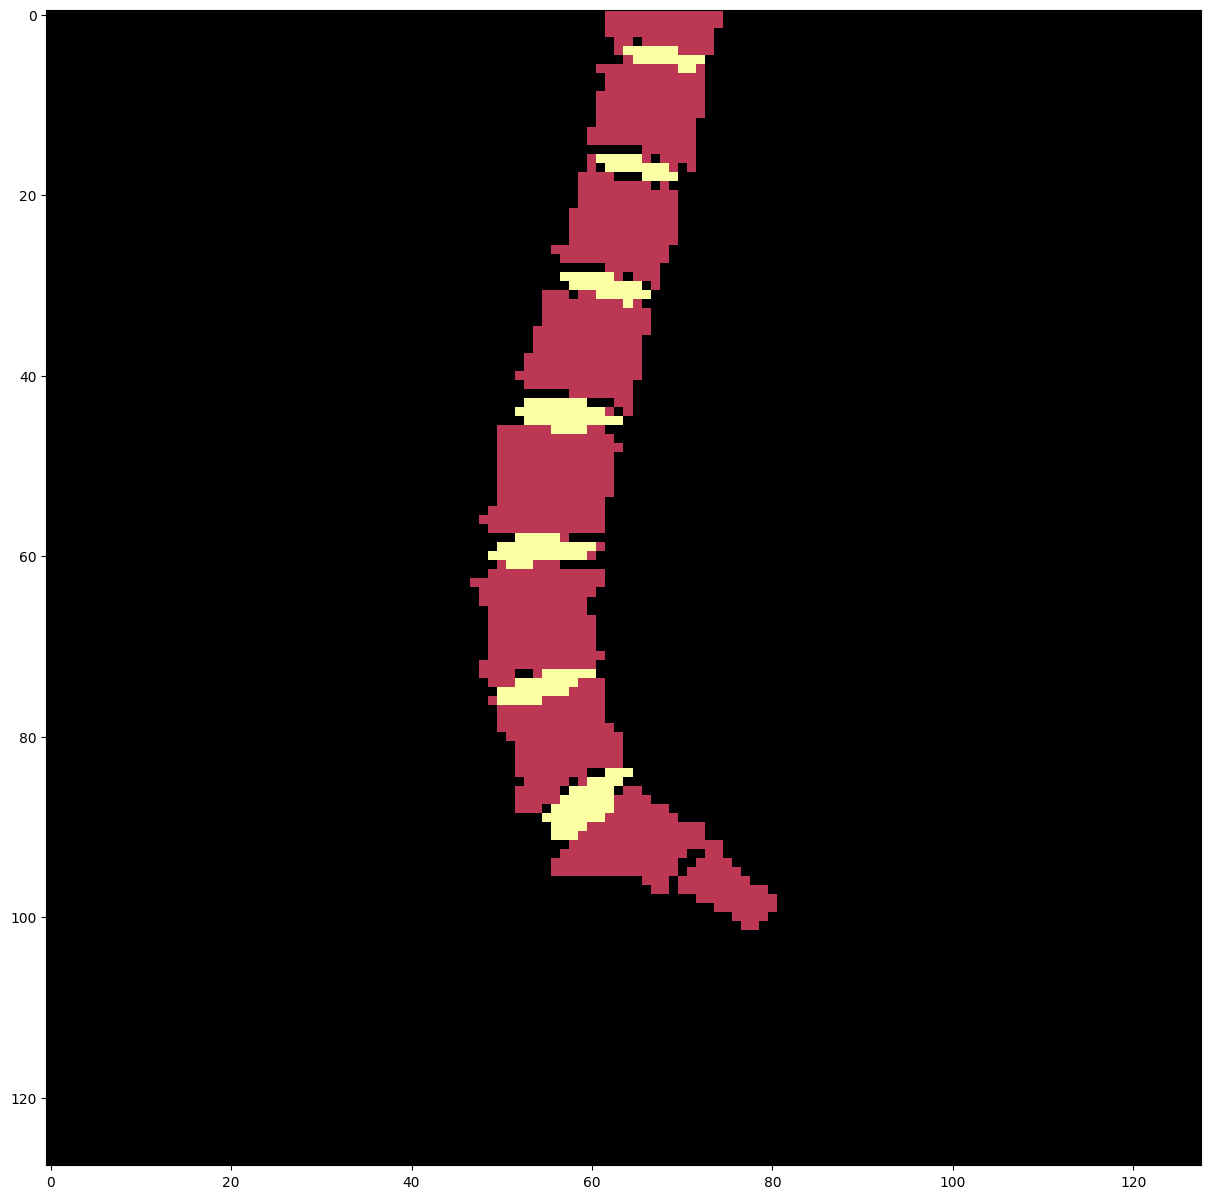

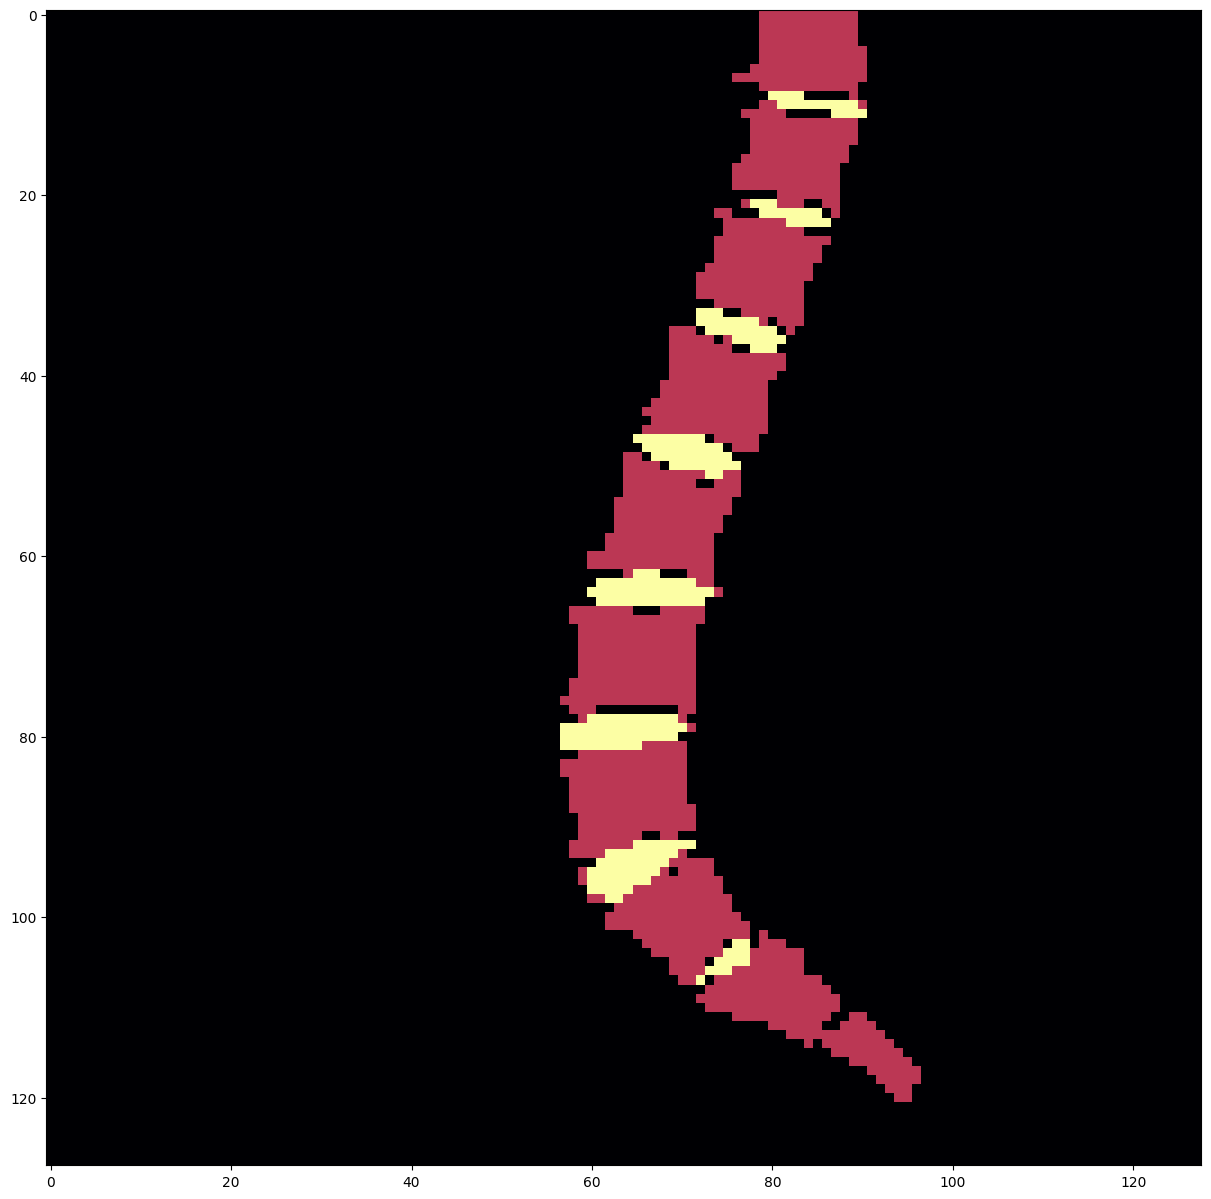

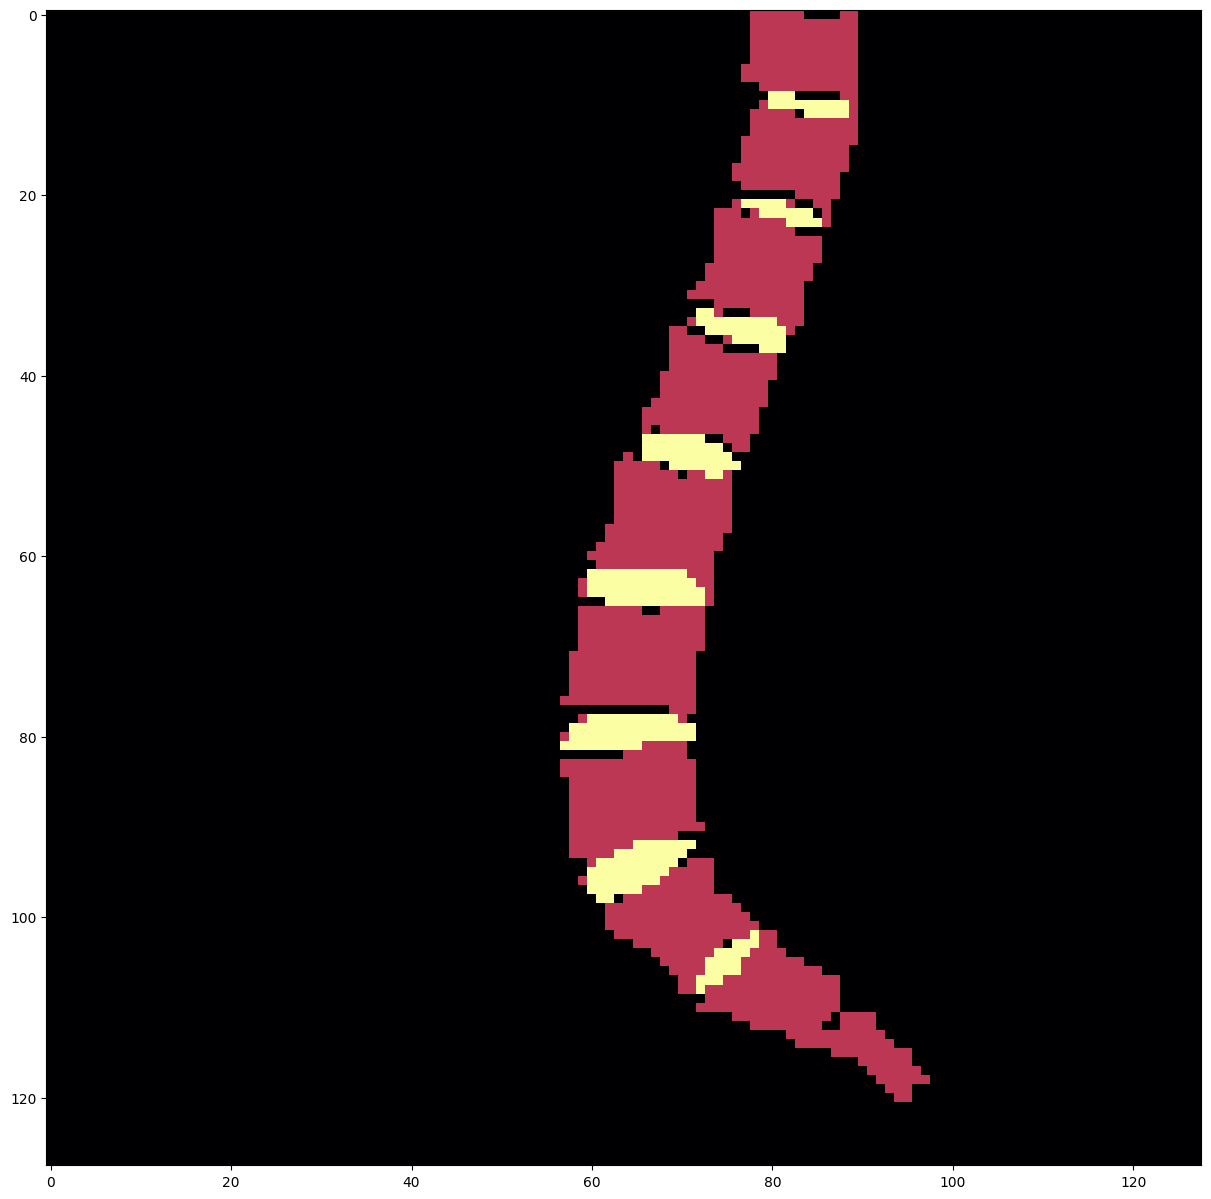

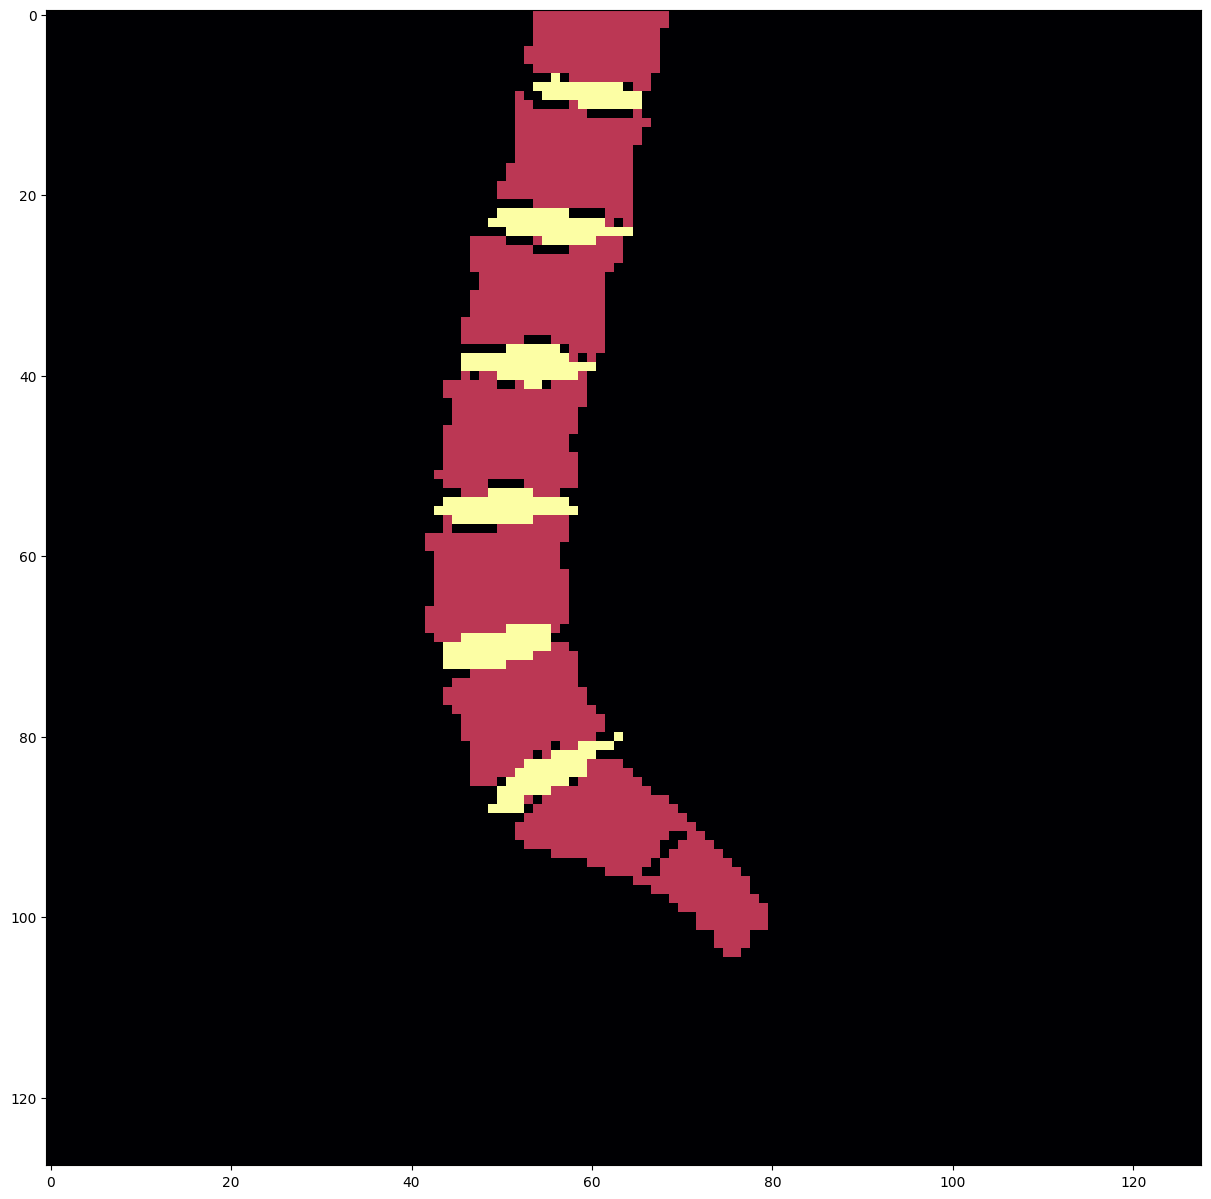

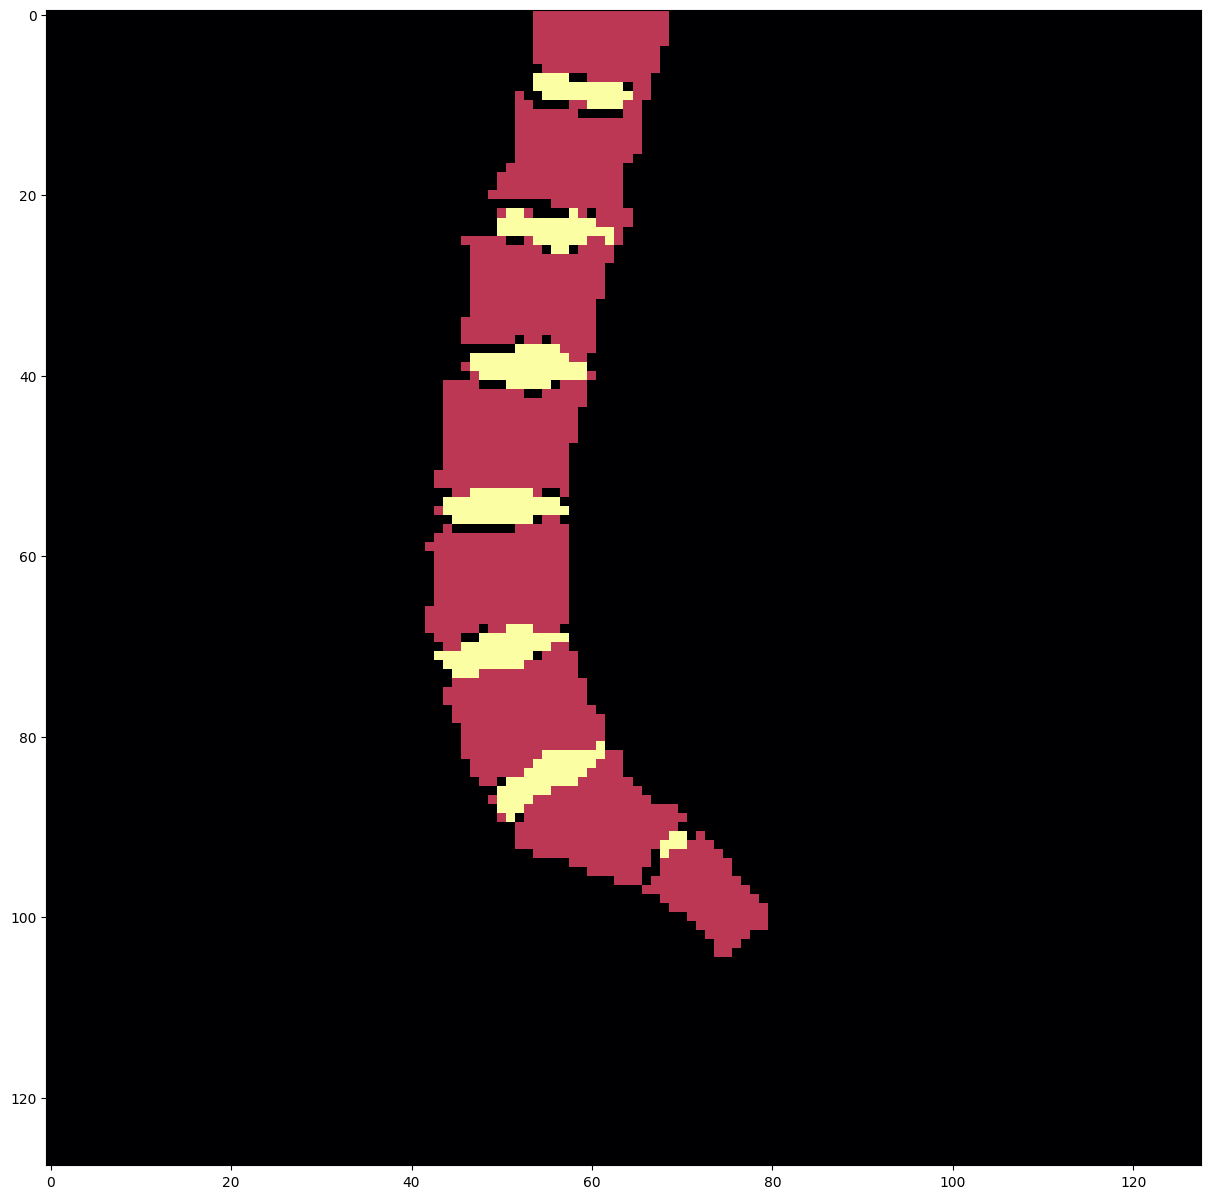

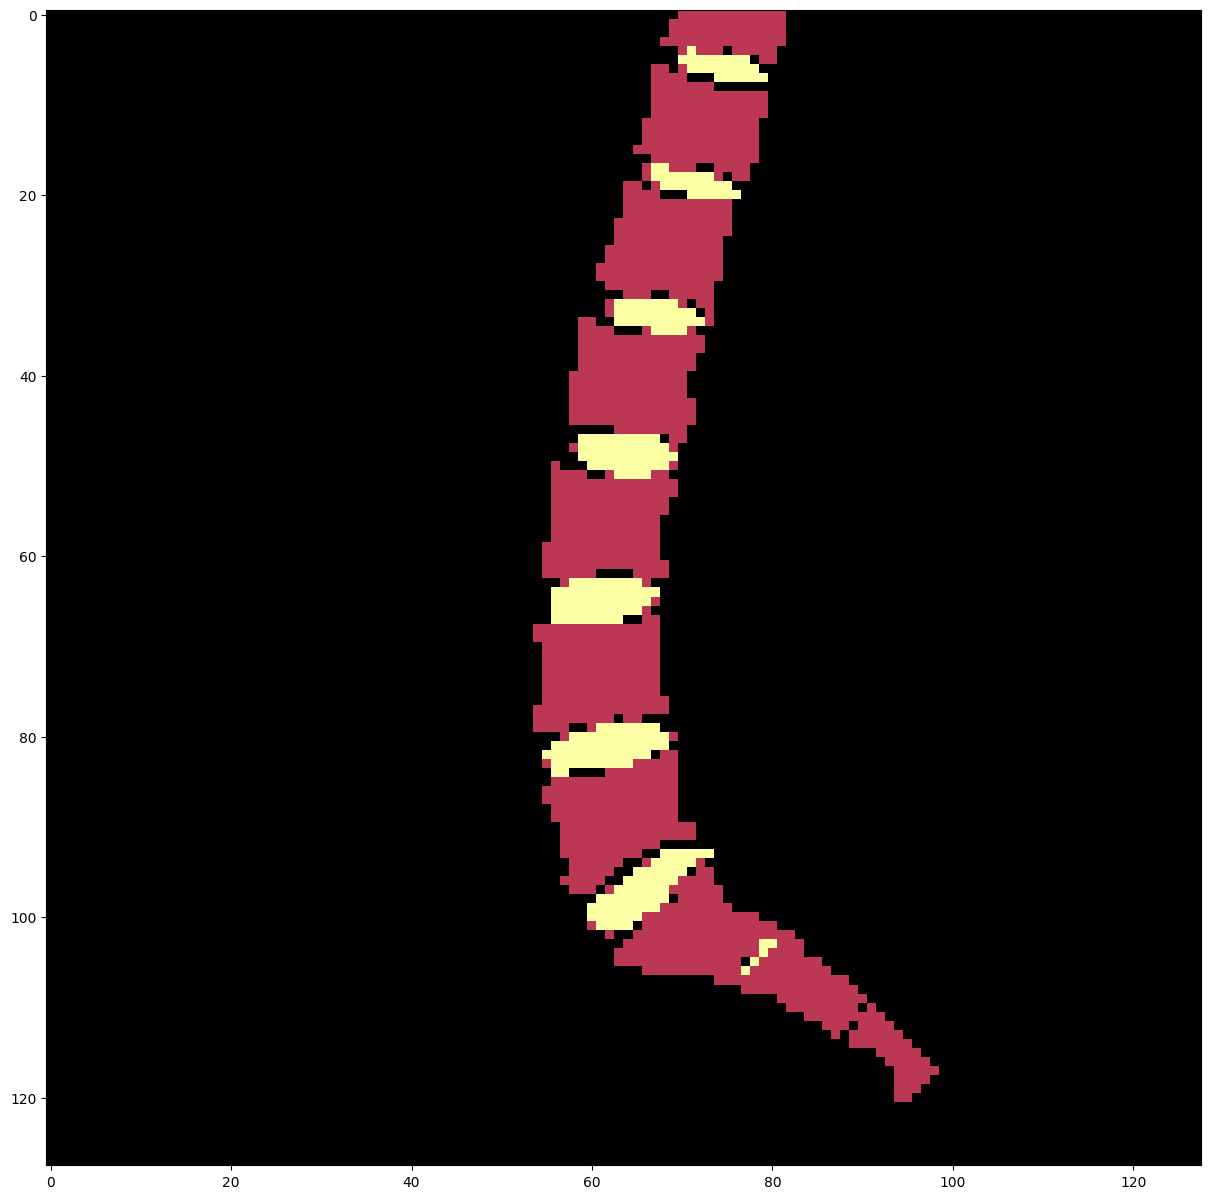

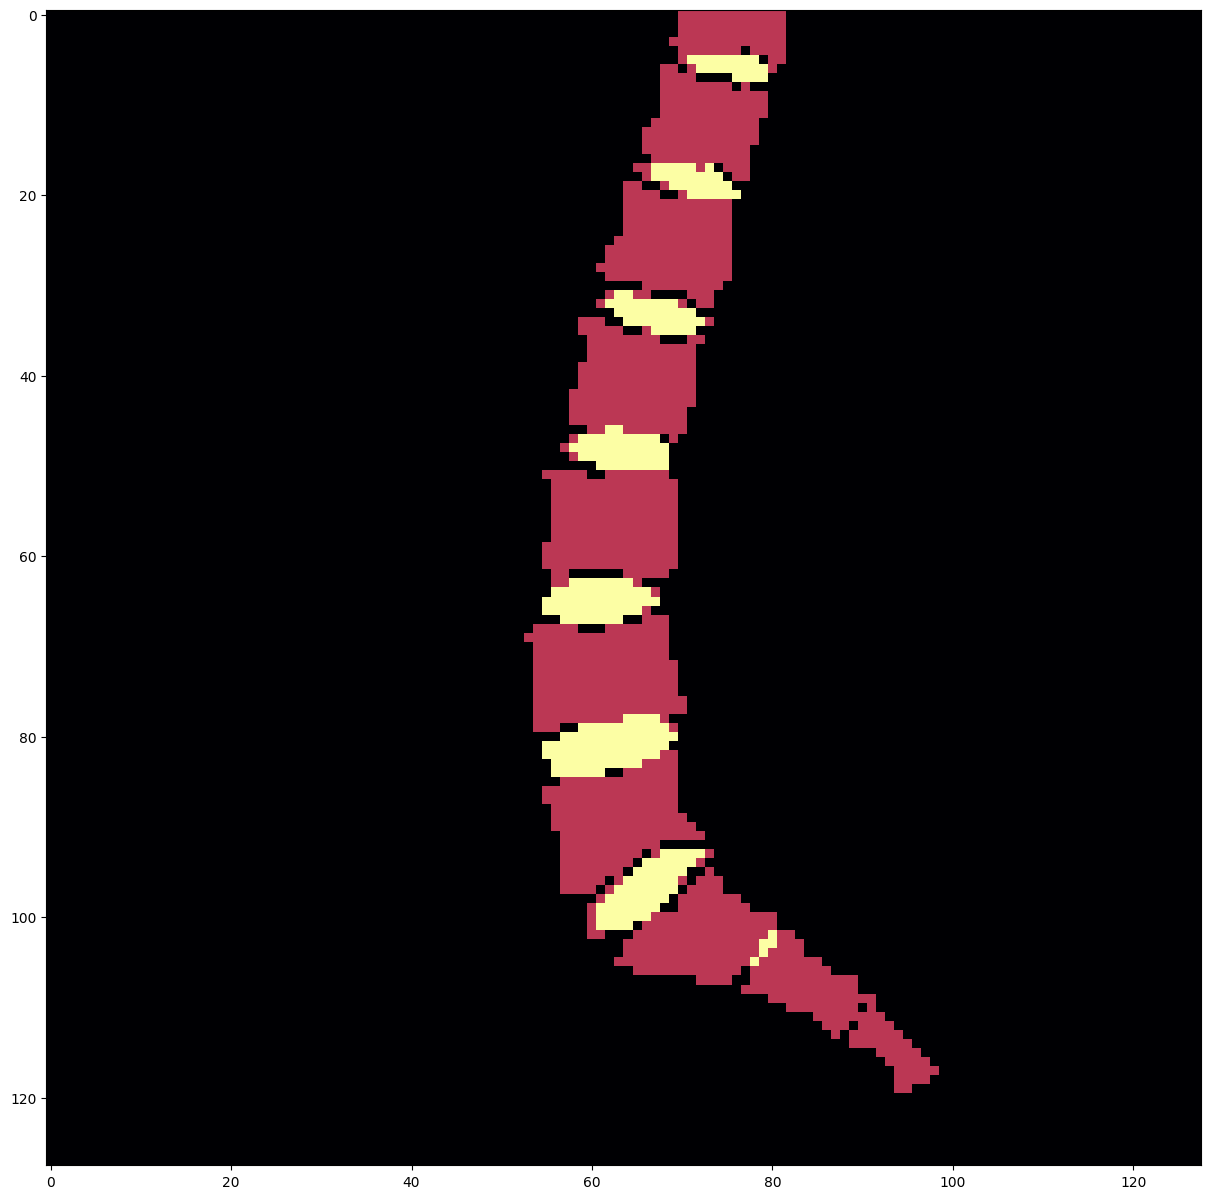

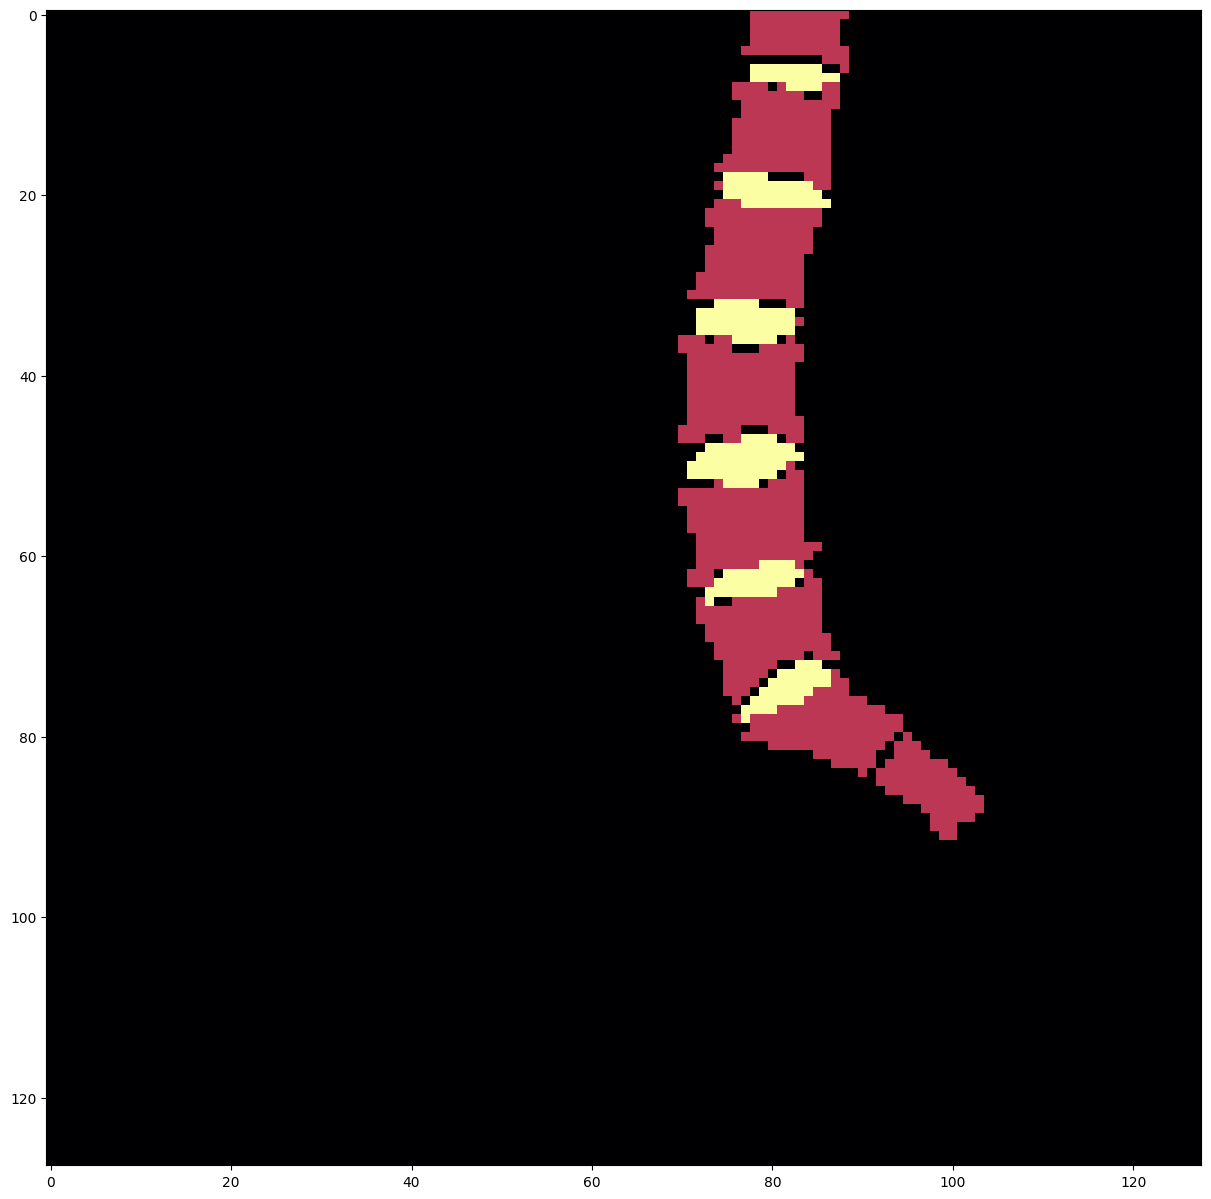

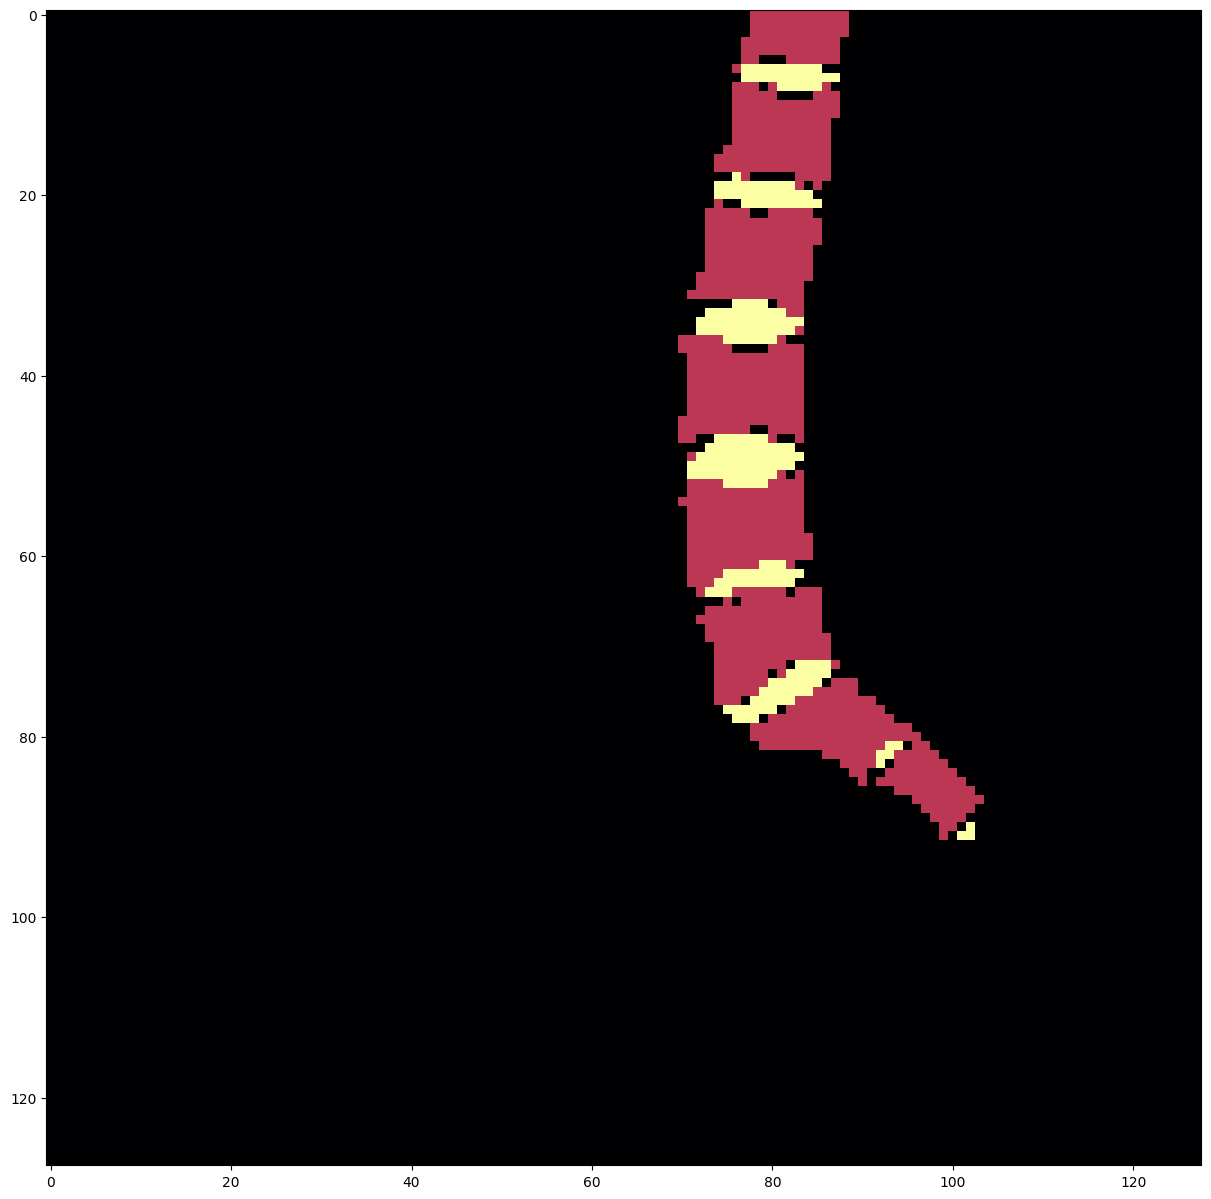

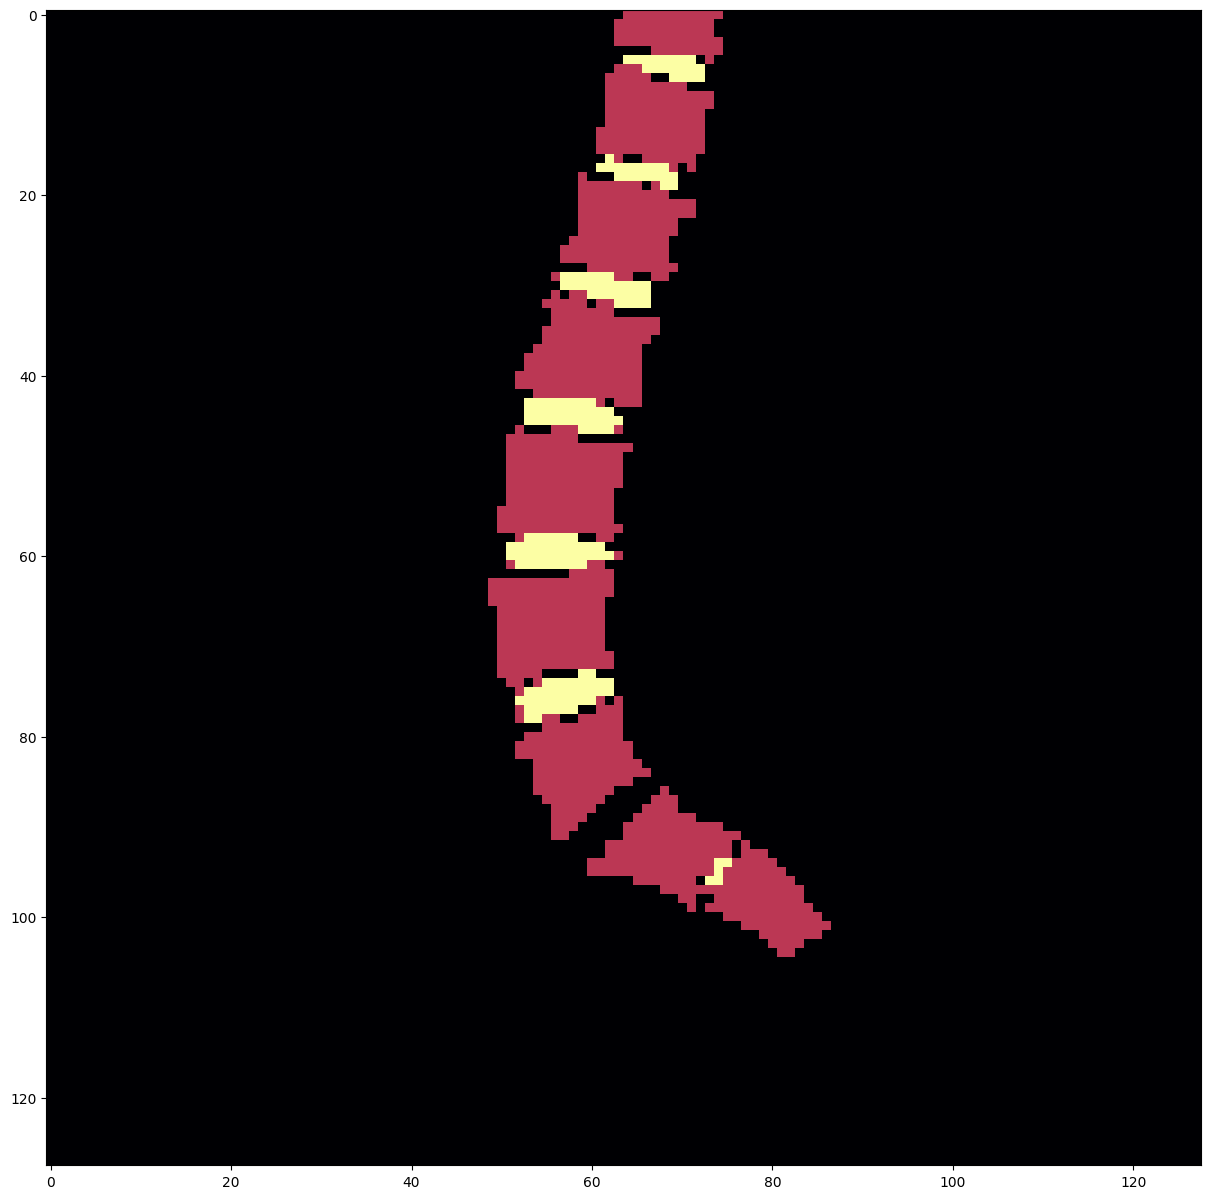

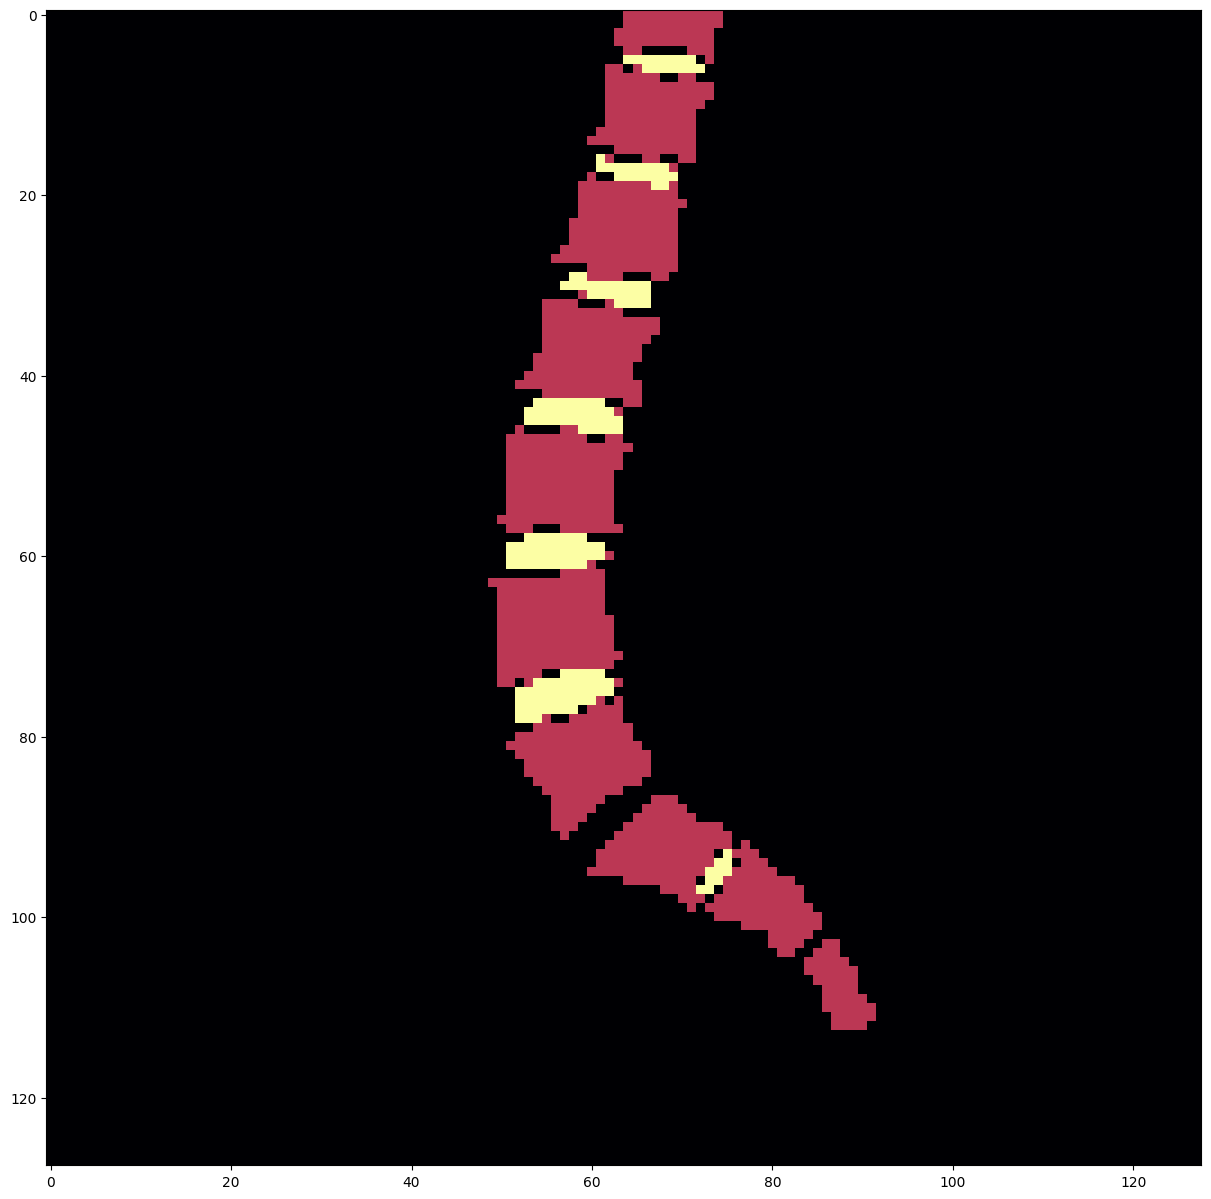

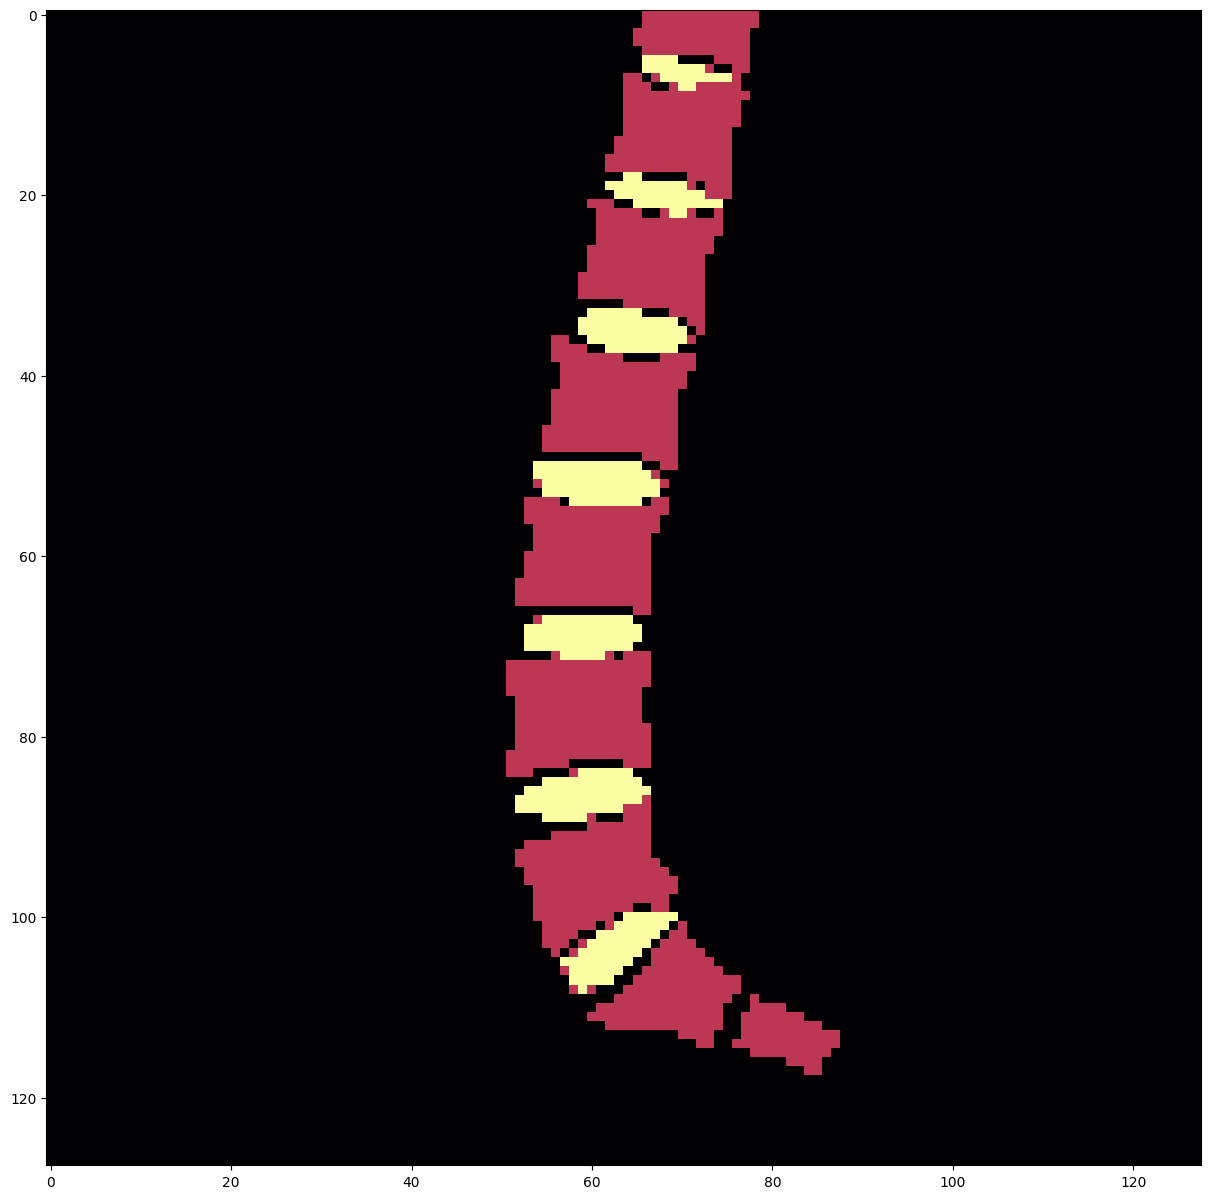

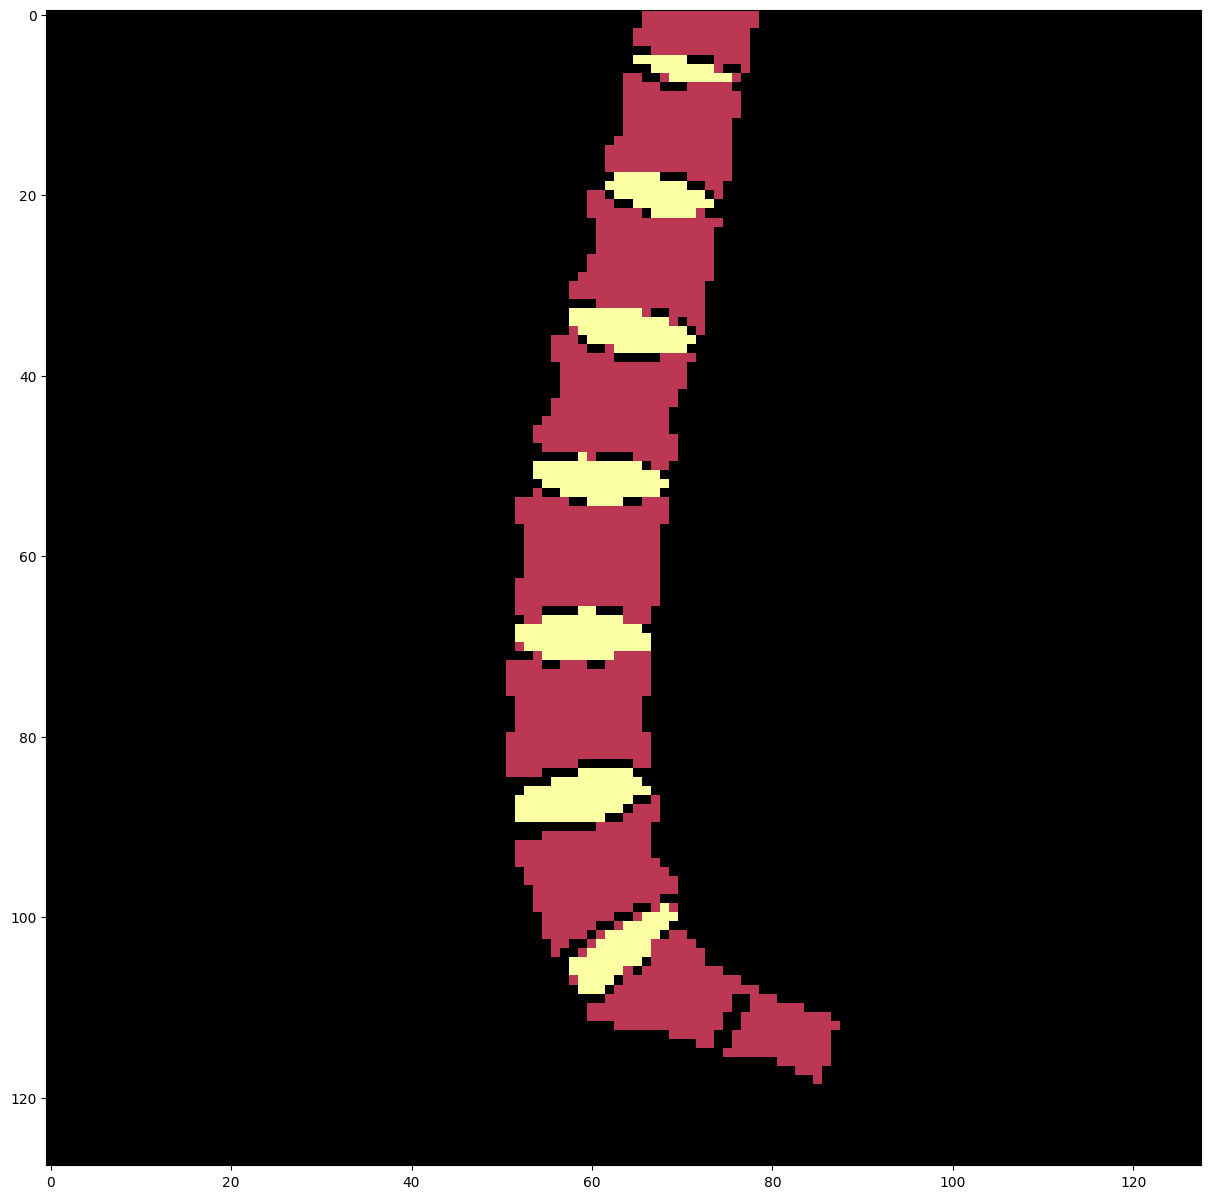

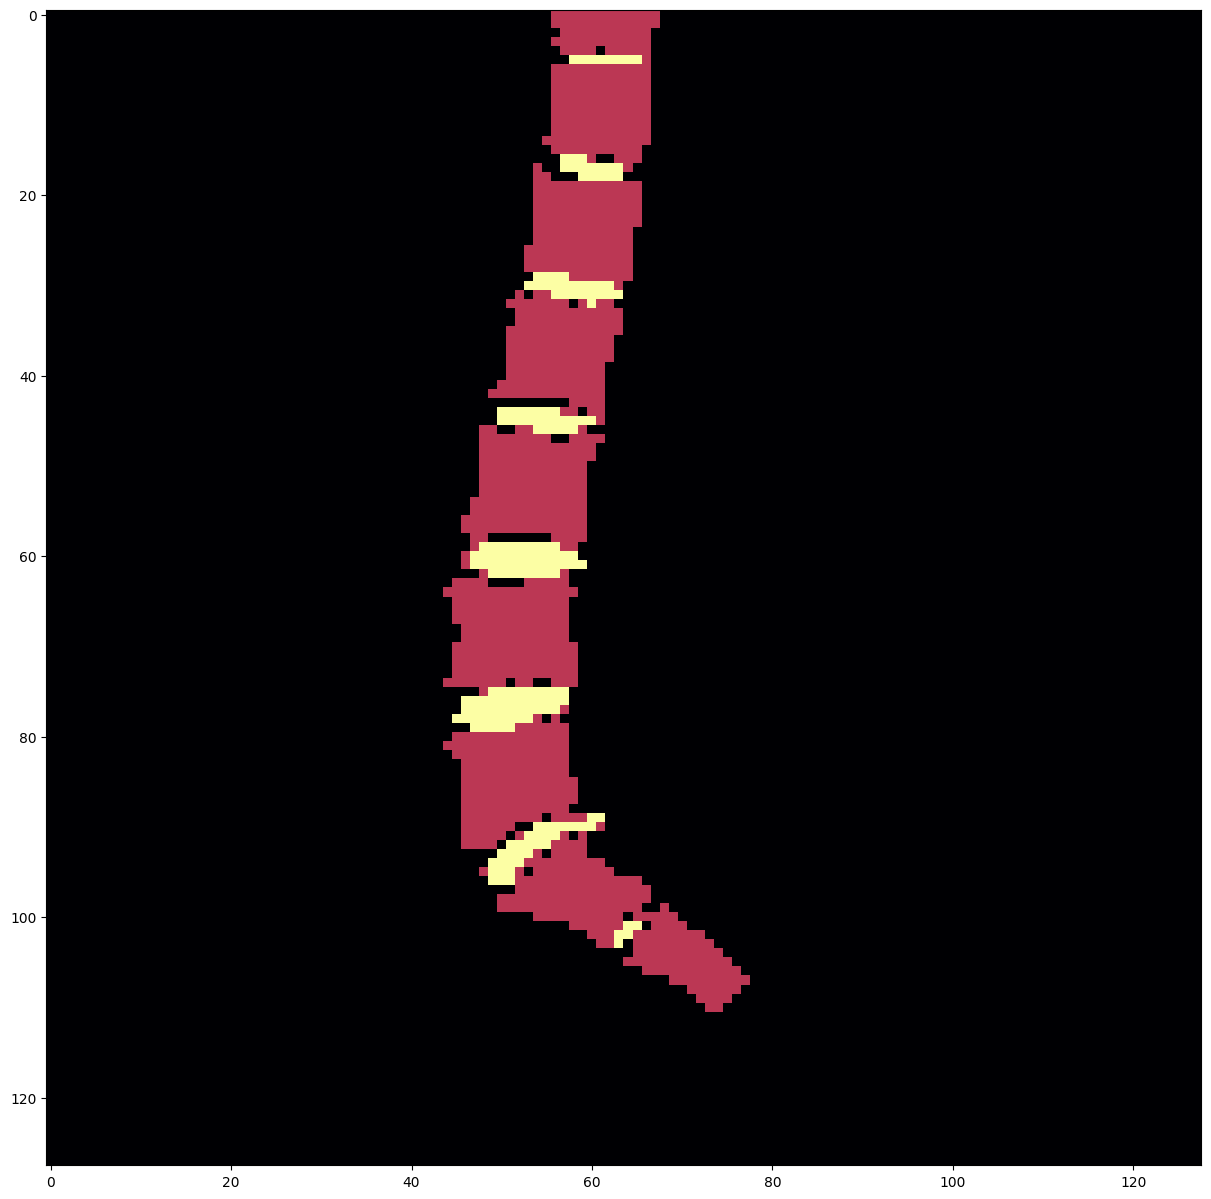

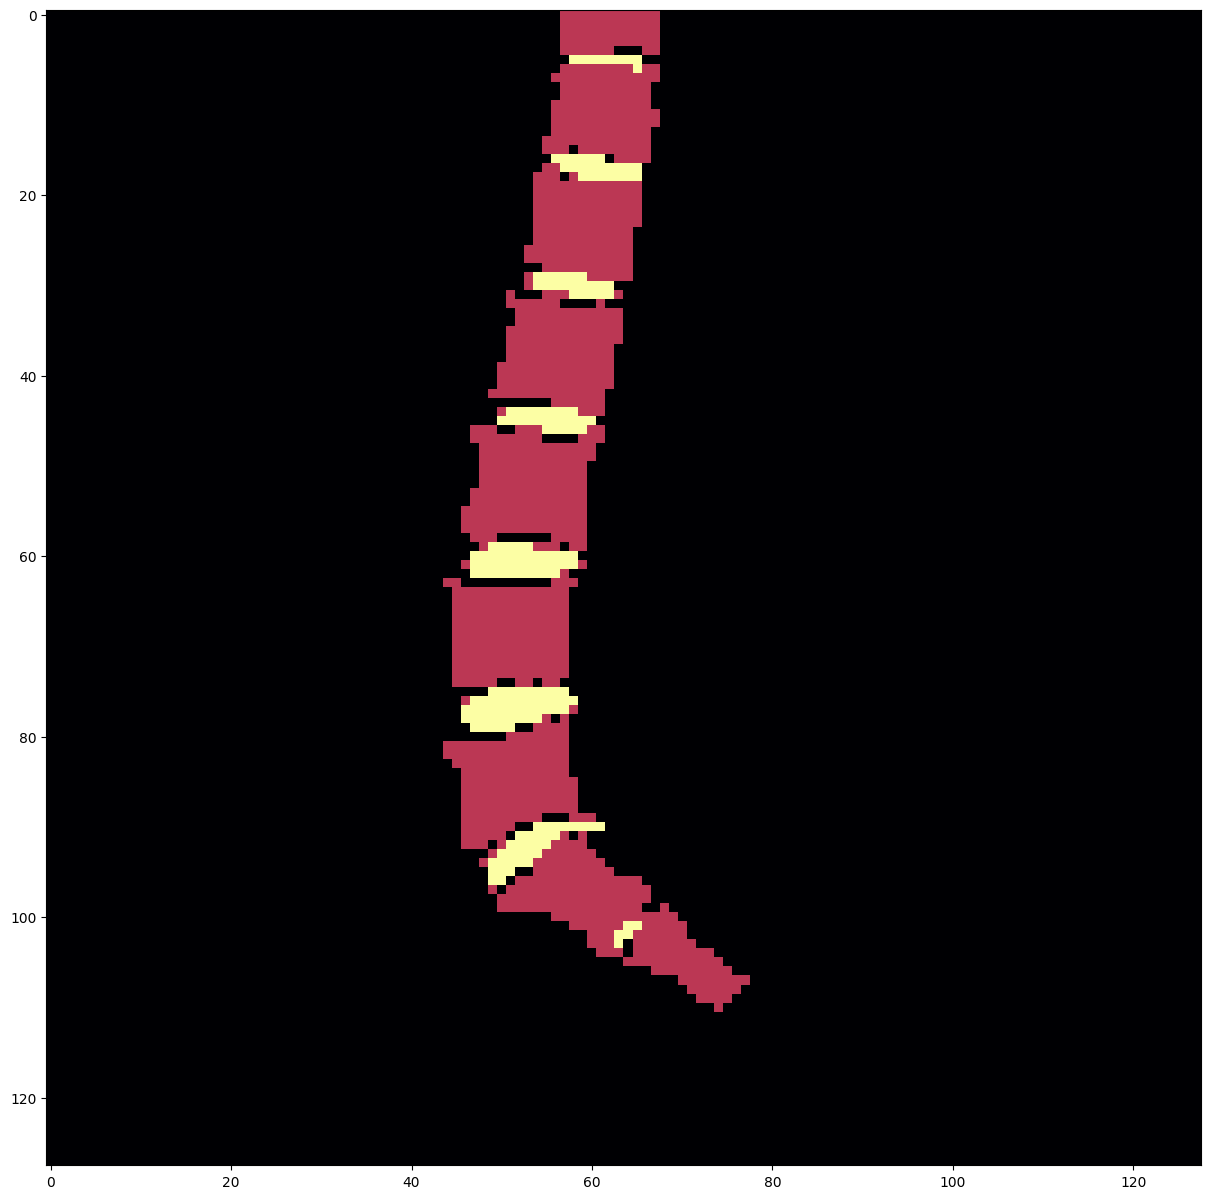

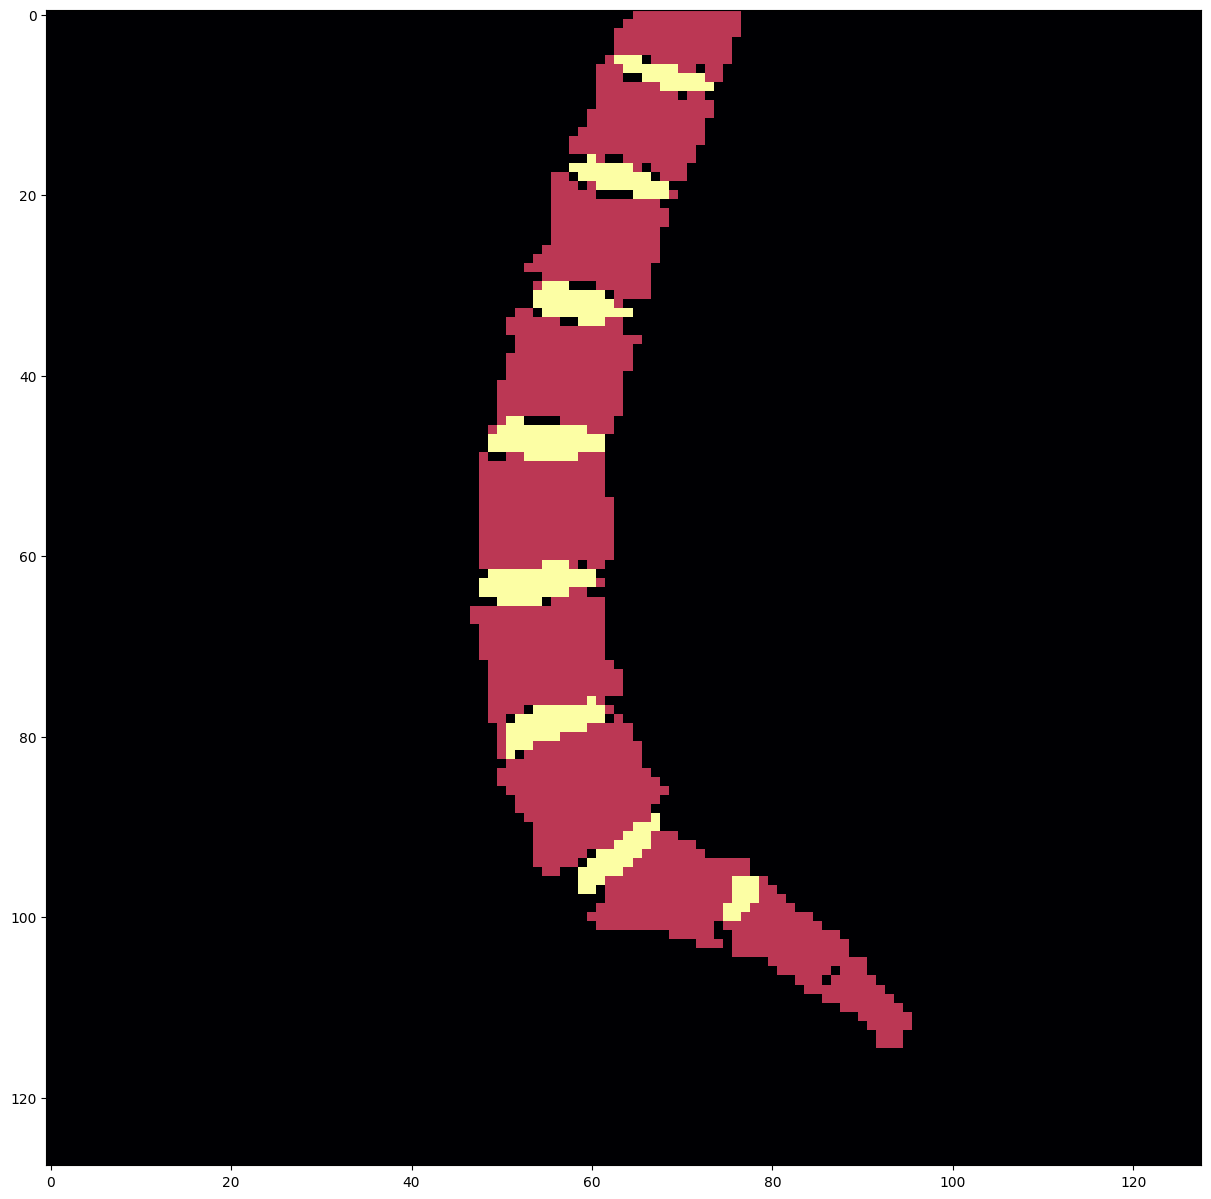

In [ ]:
mask = []
img = []

for imgId in imgs:
    filename = imgs[imgId]['filename']
    regions = imgs[imgId]['regions']

    if len(regions) <= 0:
        continue

    disc_points = []  # Координаты межпозвоночных дисков
    spine_points = []  # Координаты тел позвонков

    # Путь к изображению
    image_path = os.path.join(filename)
    # Прочитать изображение
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    mask_ = np.zeros((height, width), dtype=np.uint8)

    for region in regions:
        # Проверяем значение region_attributes
        region_attributes = region.get('region_attributes')
        if region_attributes is None:
            continue

        intervertebral_disc = region_attributes.get('intervertebral disc')
        spinal_canal =  region_attributes.get('spinal canal')

        if intervertebral_disc is not None:
            if intervertebral_disc == '1':
                # Координаты межпозвоночных дисков
                polygons = region['shape_attributes']
                disc_points = list(zip(polygons['all_points_x'], polygons['all_points_y']))
                disc_polygons = [np.array(disc_points, dtype=np.int32)]
                cv2.fillPoly(mask_, disc_polygons, color=2)

        if spinal_canal is not None:
            if spinal_canal == '2':
                # Координаты межпозвоночных дисков
                polygons = region['shape_attributes']
                spine_points = list(zip(polygons['all_points_x'], polygons['all_points_y']))
                spine_polygons = [np.array(spine_points, dtype=np.int32)]
                cv2.fillPoly(mask_, spine_polygons, color=1)


    # Уменьшить размер изображения и маски
    image = cv2.resize(image, (128, 128))
    mask_ = cv2.resize(mask_, (128, 128))

    fig, arr = plt.subplots(1, 1, figsize=(15, 15))
    arr.imshow(mask_, cmap='inferno')

    img.append(image / 255.0)
    mask.append(np.reshape(mask_,(128,128,1)))


# Преобразовать в numpy массивы
img = np.array(img)
mask = np.array(mask)
# Размеры массивов
print("Images shape:", img.shape)
print("Masks shape:", mask.shape)


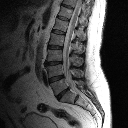

In [ ]:
cv2_imshow(image)

In [ ]:
# Блок кодера
def EncoderMiniBlock(inputs, # вход
                     n_filters=32, # количество фильтров
                     dropout_prob=0.3, # вероятность отброса
                     max_pooling=True): # использовать ли субдискретизацию

    # Два сверточных слоя (выходы) с инициализацией.
    # Набивка 'Same' не изменяет пространственные размеры.
    conv = Conv2D(n_filters,
                  3,   # размер ядра
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs) # инициализация (только при создании)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Нормализация
    conv = BatchNormalization()(conv, training=False)

    # dropout, если задан
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Суюдискретизация, если задано. Конкретно MaxPooling, уменьшает пространственные размеры в два раза
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # выход слоев ДО субдискретизации, будет передаваться в другие блоки.
    skip_connection = conv

    return next_layer, skip_connection # возвращаем выход блока и выход слоев до субдискретизации

In [ ]:
# Блок декодера
def DecoderMiniBlock(prev_layer_input, # выход предыдущего слоя (блока)
                     skip_layer_input, # выход соответствующего блока кодера
                     n_filters=32): # число фильтров

    # Транспонированная свертка увеличивает пространственный размер карты признаков в два раза
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # размер ядра
                 strides=(2,2), # увеличение размера (обратите внимание для транспонированной свертки это увеличивает размер)
                 padding='same')(prev_layer_input) # набивка, чтобы не уменьшался размер при выполнении свертки

    # Конкатенируем по каналам (измерение 3) выход транспонированной свертки и выход блока кодера
    merge = concatenate([up, skip_layer_input], axis=3)

    # Две свертки не изменяющие размеры, с инициализацией
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [ ]:
def UNetCompiled(input_size=(128, 128, 3), # размер изображения-входа
                 n_filters=32, # базовое число фильтров
                 n_classes=3): # число классов

    # Вход в сеть заданного размера
    inputs = Input(input_size)

    # Кодер

    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)

    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)

    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)

    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)

    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Декодер

    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)

    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)

    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)

    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    # слой свертки без изменения размеров карты, число фильтров по количеству классов
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Создаем модель из слоев
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
train_images, test_images, train_masks, test_masks = train_test_split(img, mask, test_size=0.2, random_state=123)

In [ ]:
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

In [ ]:
# посмотрим на сеть
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_20[0][0]']              
                                )                                                           

In [ ]:
# оптимизатор Adam, функция ошибки - кроссэнтропия которая применяет softmax к выходам сети, метрика - аккуратность
from tensorflow.keras.optimizers.legacy import Adam
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
print(train_images.shape)
print(train_masks.shape)
print(test_images.shape)
print(test_masks.shape)

(24, 128, 128, 3)
(24, 128, 128, 1)
(7, 128, 128, 3)
(7, 128, 128, 1)


In [ ]:
# Обучаем


results = unet.fit(train_images, train_masks, batch_size=2, epochs=40, validation_data=(test_images, test_masks))

Epoch 1/40
12/12 [==============================] - 24s 1s/step - loss: 0.8031 - accuracy: 0.8694 - val_loss: 0.5101 - val_accuracy: 0.9140
Epoch 2/40
12/12 [==============================] - 16s 1s/step - loss: 0.4079 - accuracy: 0.9169 - val_loss: 0.3760 - val_accuracy: 0.9140
Epoch 3/40
12/12 [==============================] - 16s 1s/step - loss: 0.2762 - accuracy: 0.9169 - val_loss: 0.2147 - val_accuracy: 0.9140
Epoch 4/40
12/12 [==============================] - 17s 1s/step - loss: 0.2101 - accuracy: 0.9169 - val_loss: 0.1984 - val_accuracy: 0.9140
Epoch 5/40
12/12 [==============================] - 17s 1s/step - loss: 0.2235 - accuracy: 0.9169 - val_loss: 0.2063 - val_accuracy: 0.9140
Epoch 6/40
12/12 [==============================] - 16s 1s/step - loss: 0.1867 - accuracy: 0.9167 - val_loss: 0.1822 - val_accuracy: 0.9199
Epoch 7/40
12/12 [==============================] - 17s 1s/step - loss: 0.1694 - accuracy: 0.9242 - val_loss: 0.1527 - val_accuracy: 0.9284
Epoch 8/40
12/12 [==

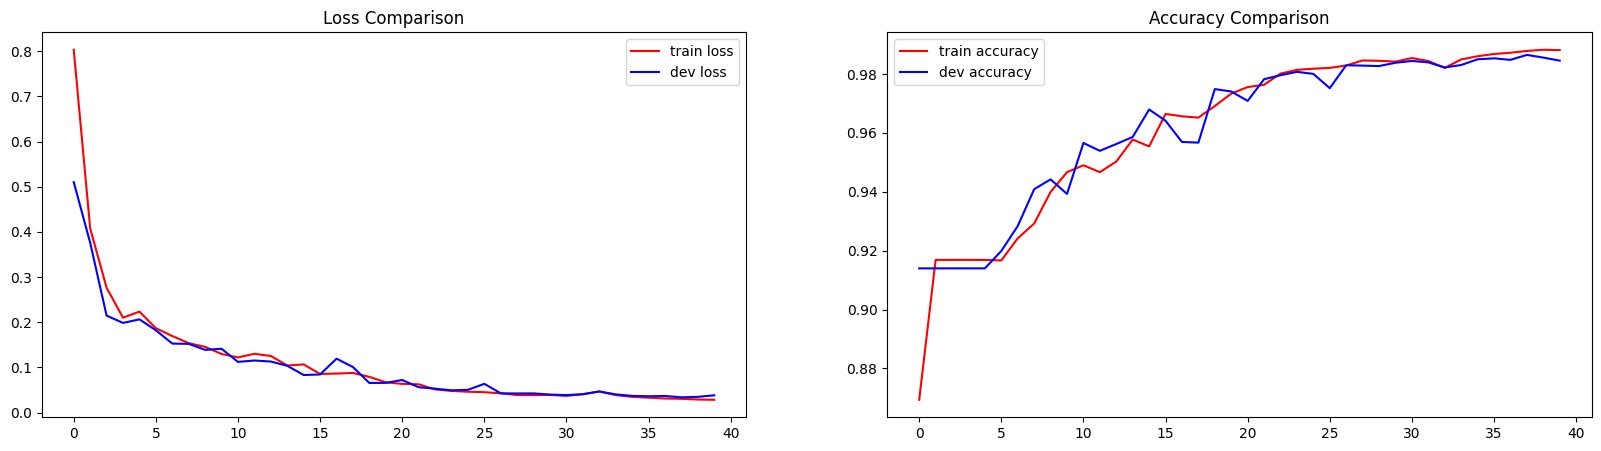

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()


In [ ]:
# рисуем
def VisualizeResults(index):
    img = test_images[index] # изображение
    img = img[np.newaxis, ...] # добавляем измерение примеров
    pred_y = unet.predict(img) # расчитываем маску
    pred_mask = tf.argmax(pred_y[0], axis=-1) # выбираем максимальный класс (канал - последнее измерение)
    pred_mask = pred_mask[..., tf.newaxis] # канальное измерение добавляем
    # рисуем
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(test_images[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(test_masks[index,:,:,0], cmap='inferno')
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0], cmap='inferno')
    arr[2].set_title('Predicted Masked Image ')

1/1 [==============================] - 0s 164ms/step


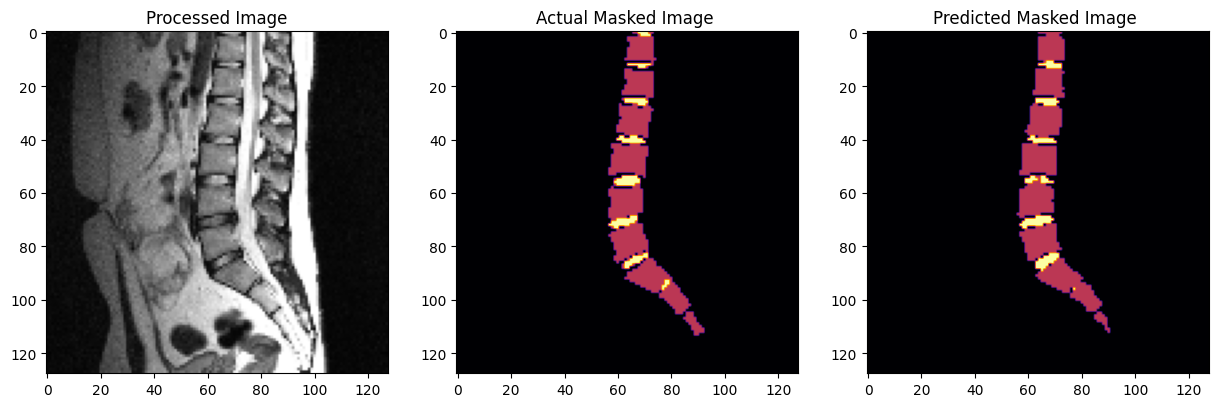

In [ ]:
# рисуем
index = 0
VisualizeResults(index)